#Analysis of Zoobot for emulated Euclid VIS images

## Import modules and data

#### Load modules

In [1]:
#Mount Google Drive with this Colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install matplotlib_scalebar

In [ ]:
!pip install numpy==1.21.6

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import PIL
import os
import pandas as pd
from scipy import optimize
from scipy import stats
from sklearn import metrics
import seaborn as sns
from PIL import Image, ImageOps
import matplotlib.colors as mcolors
from tqdm import tqdm
from matplotlib_scalebar.scalebar import ScaleBar
from astropy.io import fits
from astropy.visualization import AsinhStretch, MinMaxInterval

In [2]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

In [ ]:
!git clone https://github.com/mwalmsley/zoobot.git

In [ ]:
!pip install -e /content/zoobot[tensorflow]

In [5]:
import sys
sys.path.insert(0,'/content/zoobot')
sys.path.insert(0,'/content/galaxy-datasets')

In [6]:
from zoobot.shared import label_metadata, schemas
import zoobot.shared.stats as zoobot_stats

#### Load data

In [ ]:
#Euclid
!cp /content/drive/MyDrive/MPE/ZoobotEuclid/Data/Euclidized_COSMOS_complete/jpgs_euclid_complete.zip /content/
!unzip jpgs_euclid_complete.zip

In [ ]:
#Hubble
!cp /content/drive/MyDrive/MPE/ZoobotEuclid/Data/Hubble_COSMOS_complete/jpgs_hubble_complete.zip /content/
!unzip jpgs_hubble_complete.zip

In [ ]:
#Subaru
!cp /content/drive/MyDrive/MPE/ZoobotEuclid/Data/fits_subaru.zip /content/
!unzip fits_subaru.zip

In [10]:
#Decision Tree
hubble_pairs = {
    'smooth-or-featured-hubble': ['_smooth', '_features', '_artifact'],
    'disk-edge-on-hubble': ['_yes', '_no'],
    'has-spiral-arms-hubble': ['_yes', '_no'],
    'bar-hubble': ['_yes', '_no'],
    'bulge-size-hubble': ['_none', '_just-noticeable', '_obvious', '_dominant'],
    'how-rounded-hubble': ['_completely', '_in-between', '_cigar-shaped'],
    'bulge-shape-hubble': ['_rounded', '_boxy', '_none'],
    'spiral-winding-hubble': ['_tight', '_medium', '_loose'],
    'spiral-arm-count-hubble': ['_1', '_2', '_3', '_4', '_5-plus', '_cant-tell'],
    'clumpy-appearance-hubble': ['_yes', '_no'],
    'clump-count-hubble': ['_1', '_2', '_3', '_4', '_5-plus', '_cant-tell'],
    'galaxy-symmetrical-hubble': ['_yes', '_no'],
    'clumps-embedded-larger-object-hubble': ['_yes', '_no']
}

hubble_ortho_dependencies = {
    'smooth-or-featured-hubble': None,
    'how-rounded-hubble': 'smooth-or-featured-hubble_smooth',
    'clumpy-appearance-hubble': 'smooth-or-featured-hubble_features',
    'clump-count-hubble': 'clumpy-appearance-hubble_yes',
    'galaxy-symmetrical-hubble': 'clumpy-appearance-hubble_yes',
    'clumps-embedded-larger-object-hubble': 'clumpy-appearance-hubble_yes',
    'disk-edge-on-hubble': 'clumpy-appearance-hubble_no',
    'bulge-shape-hubble': 'disk-edge-on-hubble_yes',
    'bar-hubble': 'disk-edge-on-hubble_no',
    'has-spiral-arms-hubble': 'disk-edge-on-hubble_no',
    'spiral-winding-hubble': 'disk-edge-on-hubble_no',
    'spiral-arm-count-hubble': 'disk-edge-on-hubble_no',
    'bulge-size-hubble': 'disk-edge-on-hubble_no'
}

hubble_schema = schemas.Schema(hubble_pairs,hubble_ortho_dependencies)

In [11]:
def check_for_images(paths):
    """
        Check if images are present and remove non-existing images.
    """
    print("There are labels for",len(paths),"images.")
    print("Checking if the files exist...")
    ids_checked= []
    for i in tqdm(range(len(paths))):
        file_exists = os.path.exists(paths[i])
        if file_exists:
            ids_checked.append(str(paths[i].split("/")[-1].split(".")[0]))
    print("\nCheck over. There are actually",len(ids_checked),"images.")
    return ids_checked

In [12]:
df = pd.read_csv("/content/drive/MyDrive/MPE/ZoobotEuclid/Data/gz_hubble_labels_zoobot_complete.csv") #Complete dataset
paths = ["/content/jpgs_euclid_complete/" + str(name) for name in list(df["filename"])]
df["id_str"] = paths
ids_checked = check_for_images(paths)
filenames = [str(name)+".jpg" for name in ids_checked]

There are labels for 84954 images.
Checking if the files exist...


100%|██████████| 84954/84954 [00:00<00:00, 104402.19it/s]



Check over. There are actually 76176 images.


In [13]:
df_checked = df[df["survey_id"].astype(str).isin(ids_checked)]
df_checked

survey_id          RA       DEC   Z_BEST  MAG_BEST_HI       filename  \
20      20000084  150.721991  1.625911  999.000      21.6095   20000084.jpg   
29      20000095  150.713586  1.626127  999.000      21.6529   20000095.jpg   
89      20000347  150.711232  1.627469  999.000      21.5986   20000347.jpg   
94      20000358  150.719030  1.627365  999.000      23.4567   20000358.jpg   
104     20000369  150.662185  1.626748    0.354      21.7621   20000369.jpg   
...          ...         ...       ...      ...          ...            ...   
84949  202172042  150.572694  1.855250  999.000      23.1246  202172042.jpg   
84950  202251062  149.997296  1.839619  999.000      22.6692  202251062.jpg   
84951  202735002  149.952597  2.386713    0.867      22.9417  202735002.jpg   
84952  202882042  150.085100  2.527799    1.201      23.1505  202882042.jpg   
84953  203191082  149.591667  2.825391    0.855      21.6481  203191082.jpg   

       smooth-or-featured-hubble_smooth  smooth-or-featured-hubble_features  \
20                                 31.0                                17.0   
29                                 33.0                                 9.0   
89                                 29.0                                10.0   
94                                 29.0                                 8.0   
104                                19.0                                29.0   
...                                 ...                                 ...   
84949                               2.0                                25.0   
84950                               1.0                                 1.0   
84951                              10.0                                13.0   
84952                              19.0                                 5.0   
84953                               9.0                                13.0   

       smooth-or-featured-hubble_artifact  disk-edge-on-hubble_yes  ...  \
20                                    3.0                     14.0  ...   
29                                    5.0                      1.0  ...   
89                                    4.0                      1.0  ...   
94                                   13.0                      1.0  ...   
104                                   6.0                      0.0  ...   
...                                   ...                      ...  ...   
84949                                 5.0                      0.0  ...   
84950                                24.0                      0.0  ...   
84951                                 7.0                      0.0  ...   
84952                                 4.0                      0.0  ...   
84953                                 3.0                      1.0  ...   

       clump-count-hubble_2  clump-count-hubble_3  clump-count-hubble_4  \
20                      0.0                   0.0                   0.0   
29                      1.0                   1.0                   0.0   
89                      0.0                   0.0                   0.0   
94                      1.0                   0.0                   0.0   
104                     1.0                   7.0                   5.0   
...                     ...                   ...                   ...   
84949                   0.0                   0.0                   0.0   
84950                   0.0                   0.0                   0.0   
84951                   1.0                   0.0                   3.0   
84952                   3.0                   2.0                   0.0   
84953                   2.0                   1.0                   0.0   

       clump-count-hubble_5-plus  clump-count-hubble_cant-tell  \
20                           0.0                           2.0   
29                           0.0                           0.0   
89                           0.0                           0.0   
94                           0.0           

Question smooth-or-featured-hubble: N= 46.05 +- 0.02
Question disk-edge-on-hubble: N= 8.13 +- 0.03
Question has-spiral-arms-hubble: N= 6.52 +- 0.03
Question bar-hubble: N= 7.06 +- 0.03
Question bulge-size-hubble: N= 7.06 +- 0.03
Question how-rounded-hubble: N= 25.50 +- 0.04
Question bulge-shape-hubble: N= 1.61 +- 0.01
Question spiral-winding-hubble: N= 3.59 +- 0.03
Question spiral-arm-count-hubble: N= 3.59 +- 0.03
Question clumpy-appearance-hubble: N= 13.08 +- 0.03
Question clump-count-hubble: N= 4.96 +- 0.02
Question galaxy-symmetrical-hubble: N= 4.42 +- 0.02
Question clumps-embedded-larger-object-hubble: N= 4.42 +- 0.02


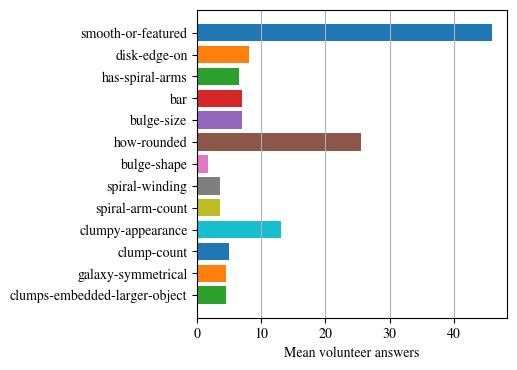

In [14]:
questions_names = list(hubble_schema.question_answer_pairs.keys())
questions_number = ["(T01)","(T02)","(T04)","(T03)","(T05)","(T07)","(T09)","(T10)","(T11)","(T12)","(T16)","(T17)","(T18)"]
questions_mean_votes, questions_std_votes = np.zeros(len(questions_names)), np.zeros(len(questions_names))

plt.figure(figsize=(4,4))
for i in range(len(questions_names)):
    answers = [questions_names[i]+answer for answer in hubble_schema.question_answer_pairs[questions_names[i]]]
    number_votes = np.sum(np.array(df_checked[answers]),axis=1)
    mean_votes, std_votes = np.mean(number_votes), np.std(number_votes)/np.sqrt(len(df_checked))
    print("Question {}: N= {:.2f} +- {:.2f}".format(questions_names[i],mean_votes,std_votes))
    questions_mean_votes[i] = mean_votes
    questions_std_votes[i] = std_votes
    plt.barh(questions_names[i].replace("-hubble",""),questions_mean_votes[i])

plt.gca().invert_yaxis()
plt.grid()
plt.xlabel("Mean volunteer answers")
plt.grid(axis="y")
#plt.savefig("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/new/plots/gzh_mean_num_votes.pdf",bbox_inches='tight')

In [15]:
data = pd.read_csv("/content/drive/MyDrive/MPE/ZoobotEuclid/Data/gz_hubble_main.csv")
data = data[data["imaging"]=="COSMOS"]
metadata = pd.read_csv("/content/drive/MyDrive/MPE/ZoobotEuclid/Data/metadata_main.csv")
id_strs = list(metadata["survey_id"])
data = pd.merge(data,metadata,on="survey_id")
data = data[data["survey_id"].astype(str).isin(ids_checked)]
data

<ipython-input-15-e2cab3b9144a>:3: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv("/content/drive/MyDrive/MPE/ZoobotEuclid/Data/metadata_main.csv")


zooniverse_id_x  survey_id   Table        RA_x     DEC_x  Z_BEST_x  \
20         AHZ200000l   20000084  hubble  150.721991  1.625911   999.000   
29         AHZ200000u   20000095  hubble  150.713586  1.626127   999.000   
89         AHZ200002i   20000347  hubble  150.711232  1.627469   999.000   
94         AHZ200002n   20000358  hubble  150.719030  1.627365   999.000   
104        AHZ200002x   20000369  hubble  150.662185  1.626748     0.354   
...               ...        ...     ...         ...       ...       ...   
84949      AHZ2001tjq  202172042  hubble  150.572694  1.855250   999.000   
84950      AHZ2001tjr  202251062  hubble  149.997296  1.839619   999.000   
84951      AHZ2001tjs  202735002  hubble  149.952597  2.386713     0.867   
84952      AHZ2001tjt  202882042  hubble  150.085100  2.527799     1.201   
84953      AHZ2001tju  203191082  hubble  149.591667  2.825391     0.855   

         GZ_MU_I imaging_x  correction_type  total_count  ...  \
20     18.176240    COSMOS              4.0          206  ...   
29     18.124786    COSMOS              4.0          171  ...   
89     17.846295    COSMOS              4.0          167  ...   
94     20.141721    COSMOS              4.0          157  ...   
104    20.036808    COSMOS              0.0          318  ...   
...          ...       ...              ...          ...  ...   
84949  20.421680    COSMOS              4.0          236  ...   
84950  20.806688    COSMOS              4.0           36  ...   
84951  20.362578    COSMOS              0.0          153  ...   
84952  18.528623    COSMOS              3.0          104  ...   
84953  19.909925    COSMOS              0.0          149  ...   

       REERR_GALFIT_HI  REERR_GALFIT_LOW  NERR_GALFIT_HI  NERR_GALFIT_LOW  \
20                0.27            -999.0            0.02           -999.0   
29                0.59            -999.0            0.23           -999.0   
89                0.43            -999.0            0.11           -999.0   
94                0.71            -999.0            0.08           -999.0   
104               0.17            -999.0            0.02           -999.0   
...                ...               ...             ...              ...   
84949             2.05            -999.0            0.41           -999.0   
84950             1.45            -999.0            0.01           -999.0   
84951            17.50            -999.0            0.79           -999.0   
84952             0.07            -999.0            0.08           -999.0   
84953             0.32            -999.0            0.02           -999.0   

       BAERR_GALFIT_HI  BAERR_GALFIT_LOW  PAERR_GALFIT_HI  PAERR_GALFIT_LOW  \
20                0.00            -999.0             0.09            -999.0   
29                0.01            -999.0             1.64            -999.0   
89                0.01            -999.0             2.02            -999.0   
94                0.02            -999.0             1.64            -999.0   
104               0.01            -999.0             0.96            -999.0   
...                ...               ...              ...               ...   
84949             0.04            -999.0             2.87            -999.0   
84950             0.01            -999.0             0.44            -999.0   
84951             0.02            -999.0             1.87            -999.0   
84952             0.01            -999.0             1.19            -999.0   
84953             0.01            -999.0             0.90            -999.0   

       z_spec_flag  z_spec_conflict_flag  
20             0.0                 False  
29             0.0                 False  
89             0.0                 False  
94             0.0                 False  
104            0.0                 False  
...            ...                   ...  
84949          0.0                 False  
84950          0.0                 False  
84951          0.0                 False  
84952   

Image size
Min: 10.5
Max: 38.25
Mean: 12.450000000000001


Text(0, 0.5, 'Number of cutouts')

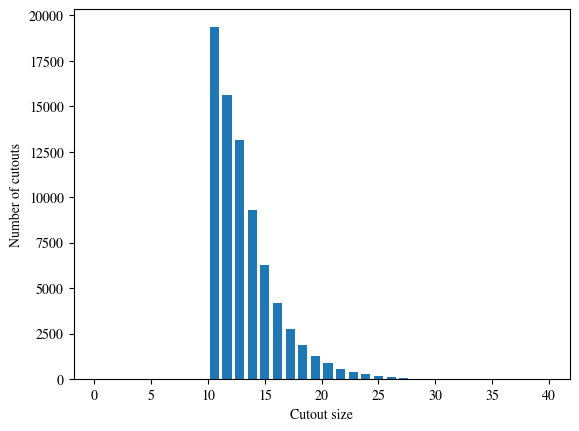

In [16]:
print("Image size")
print("Min:",3*np.min(data["KRON_RADIUS_HI"]))
print("Max:",3*np.max(data["KRON_RADIUS_HI"]))
print("Mean:",3*np.median(data["KRON_RADIUS_HI"]))

sizes = np.array(3*data["KRON_RADIUS_HI"])
sizes_hist = np.histogram(sizes, bins=36, range=(0,40))
plt.bar(sizes_hist[1][:-1]+0.5*(sizes_hist[1][1]-sizes_hist[1][0]),sizes_hist[0])
plt.xlabel("Cutout size")
plt.ylabel("Number of cutouts")

In [17]:
def get_answers_frac(data,column_total,bins_mag):

    #Get number of volunteers
    number_votes = data['t01_smooth_or_features_total_count']
    half_num_votes = np.array(number_votes)/2

    nums_mag = np.zeros(len(bins_mag)-1)

    num_rel, num_total = 0, len(number_votes)
    for i in range(len(data)):
        if data[column_total].iloc[i] > half_num_votes[i]:
            num_rel += 1
            for j in range(len(bins_mag)-1):
                if data["MAG_BEST_HI"].iloc[i]>bins_mag[j] and data["MAG_BEST_HI"].iloc[i]<bins_mag[j+1]:
                    nums_mag[j] = nums_mag[j]+1
    frac = num_rel/num_total
    nums_mag_norm = np.array(nums_mag)/num_rel
    print("{} - N_relevant = {:.0f}, N = {:.0f} --> Fraction: {:.1%}".format(column_total,num_rel,num_total,frac))
    print(nums_mag)
    return nums_mag, nums_mag_norm

In [18]:
bins_mag = np.arange(17.5,24.5,1.5)
print(bins_mag)
columns_total = ['t01_smooth_or_features','t02_edgeon','t03_bar','t04_spiral','t05_bulge_prominence','t07_rounded','t09_bulge_shape','t10_arms_winding','t11_arms_number','t12_clumpy','t16_clumps_count','t17_clumps_symmetrical','t18_clumps_embedded']

[17.5 19.  20.5 22.  23.5]


In [19]:
nums_answers_mag, nums_answers_mag_norm = [], []
for i in range(len(hubble_schema.questions)):
    nums_answer_mag, nums_answer_mag_norm = get_answers_frac(data,columns_total[i]+"_total_count",bins_mag)
    nums_answers_mag.append(nums_answer_mag)
    nums_answers_mag_norm.append(nums_answer_mag_norm)
nums_answers_mag = np.array(nums_answers_mag)
nums_answers_mag_norm = np.array(nums_answers_mag_norm)

t01_smooth_or_features_total_count - N_relevant = 76176, N = 76176 --> Fraction: 100.0%
[ 1355.  4439. 16586. 53009.]
t02_edgeon_total_count - N_relevant = 4669, N = 76176 --> Fraction: 6.1%
[ 455. 1551. 2119.  462.]
t03_bar_total_count - N_relevant = 4652, N = 76176 --> Fraction: 6.1%
[ 398. 1422. 2238.  523.]
t04_spiral_total_count - N_relevant = 3726, N = 76176 --> Fraction: 4.9%
[ 366. 1246. 1731.  315.]
t05_bulge_prominence_total_count - N_relevant = 4655, N = 76176 --> Fraction: 6.1%
[ 398. 1424. 2238.  524.]
t07_rounded_total_count - N_relevant = 48436, N = 76176 --> Fraction: 63.6%
[  264.  1720.  9537. 36883.]
t09_bulge_shape_total_count - N_relevant = 344, N = 76176 --> Fraction: 0.5%
[ 40. 109. 138.  52.]
t10_arms_winding_total_count - N_relevant = 3652, N = 76176 --> Fraction: 4.8%
[ 336. 1206. 1725.  324.]
t11_arms_number_total_count - N_relevant = 3650, N = 76176 --> Fraction: 4.8%
[ 336. 1206. 1724.  323.]
t12_clumpy_total_count - N_relevant = 10589, N = 76176 --> Fracti

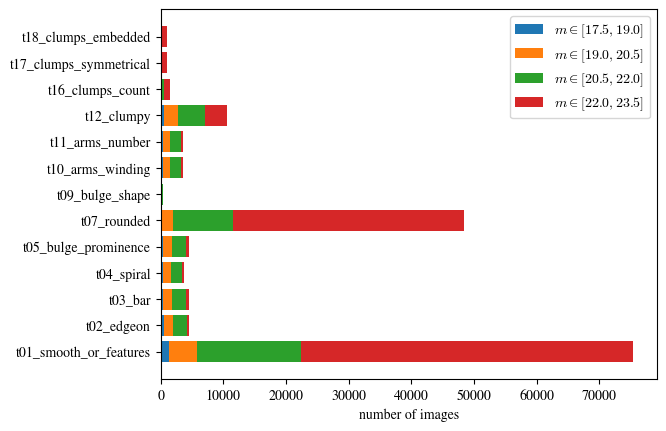

In [ ]:
for j in range(0,len(bins_mag)-1):
    offsets = nums_answers_mag[:,:j].sum(axis=1)
    plt.barh(columns_total,nums_answers_mag[:,j],left=offsets,label="$m\in[{:.1f},{:.1f}]$".format(bins_mag[j],bins_mag[j+1]))
plt.xlabel("number of images")
plt.legend()
#plt.xscale("log")

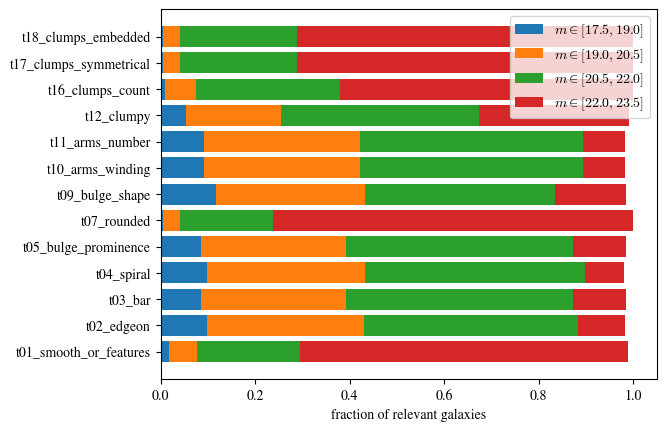

In [ ]:
for j in range(0,len(bins_mag)-1):
    offsets = nums_answers_mag_norm[:,:j].sum(axis=1)
    plt.barh(columns_total,nums_answers_mag_norm[:,j],left=offsets,label="$m\in[{:.1f},{:.1f}]$".format(bins_mag[j],bins_mag[j+1]))
plt.xlabel("fraction of relevant galaxies")
plt.legend()

## Examples Hubble vs Euclid

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/MPE/ZoobotEuclid/Data/gz_hubble_main.csv")
data = data[data["imaging"]=="COSMOS"]
metadata = pd.read_csv("/content/drive/MyDrive/MPE/ZoobotEuclid/Data/metadata_main.csv")
id_strs = list(metadata["survey_id"])
data = pd.merge(data,metadata,on="survey_id")
metadata = data[data["survey_id"].astype(str).isin(ids_checked)]
metadata

<ipython-input-18-4c1c956bee4f>:3: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv("/content/drive/MyDrive/MPE/ZoobotEuclid/Data/metadata_main.csv")


zooniverse_id_x  survey_id   Table        RA_x     DEC_x  Z_BEST_x  \
20         AHZ200000l   20000084  hubble  150.721991  1.625911   999.000   
29         AHZ200000u   20000095  hubble  150.713586  1.626127   999.000   
89         AHZ200002i   20000347  hubble  150.711232  1.627469   999.000   
94         AHZ200002n   20000358  hubble  150.719030  1.627365   999.000   
104        AHZ200002x   20000369  hubble  150.662185  1.626748     0.354   
...               ...        ...     ...         ...       ...       ...   
84949      AHZ2001tjq  202172042  hubble  150.572694  1.855250   999.000   
84950      AHZ2001tjr  202251062  hubble  149.997296  1.839619   999.000   
84951      AHZ2001tjs  202735002  hubble  149.952597  2.386713     0.867   
84952      AHZ2001tjt  202882042  hubble  150.085100  2.527799     1.201   
84953      AHZ2001tju  203191082  hubble  149.591667  2.825391     0.855   

         GZ_MU_I imaging_x  correction_type  total_count  ...  \
20     18.176240    COSMOS              4.0          206  ...   
29     18.124786    COSMOS              4.0          171  ...   
89     17.846295    COSMOS              4.0          167  ...   
94     20.141721    COSMOS              4.0          157  ...   
104    20.036808    COSMOS              0.0          318  ...   
...          ...       ...              ...          ...  ...   
84949  20.421680    COSMOS              4.0          236  ...   
84950  20.806688    COSMOS              4.0           36  ...   
84951  20.362578    COSMOS              0.0          153  ...   
84952  18.528623    COSMOS              3.0          104  ...   
84953  19.909925    COSMOS              0.0          149  ...   

       REERR_GALFIT_HI  REERR_GALFIT_LOW  NERR_GALFIT_HI  NERR_GALFIT_LOW  \
20                0.27            -999.0            0.02           -999.0   
29                0.59            -999.0            0.23           -999.0   
89                0.43            -999.0            0.11           -999.0   
94                0.71            -999.0            0.08           -999.0   
104               0.17            -999.0            0.02           -999.0   
...                ...               ...             ...              ...   
84949             2.05            -999.0            0.41           -999.0   
84950             1.45            -999.0            0.01           -999.0   
84951            17.50            -999.0            0.79           -999.0   
84952             0.07            -999.0            0.08           -999.0   
84953             0.32            -999.0            0.02           -999.0   

       BAERR_GALFIT_HI  BAERR_GALFIT_LOW  PAERR_GALFIT_HI  PAERR_GALFIT_LOW  \
20                0.00            -999.0             0.09            -999.0   
29                0.01            -999.0             1.64            -999.0   
89                0.01            -999.0             2.02            -999.0   
94                0.02            -999.0             1.64            -999.0   
104               0.01            -999.0             0.96            -999.0   
...                ...               ...              ...               ...   
84949             0.04            -999.0             2.87            -999.0   
84950             0.01            -999.0             0.44            -999.0   
84951             0.02            -999.0             1.87            -999.0   
84952             0.01            -999.0             1.19            -999.0   
84953             0.01            -999.0             0.90            -999.0   

       z_spec_flag  z_spec_conflict_flag  
20             0.0                 False  
29             0.0                 False  
89             0.0                 False  
94             0.0                 False  
104            0.0                 False  
...            ...                   ...  
84949          0.0                 False  
84950          0.0                 False  
84951          0.0                 False  
84952   

In [ ]:
def arcsinh_stretch_ds9(data, a=10, factor=3):
    #https://ds9.si.edu/doc/ref/how.html
    return np.arcsinh(data * a)/factor

10.5
11.34
13.049999999999999
11.25


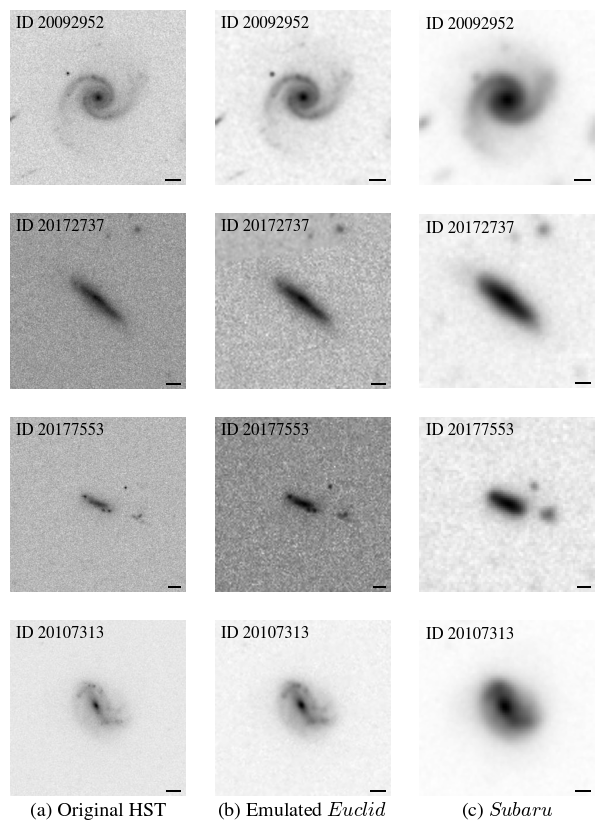

In [ ]:
ids = ["20092952", "20172737", "20177553", "20107313"] #20177553 for clumps
fig, ax = plt.subplots(nrows=4, ncols=3,figsize=(6,8))
fig.tight_layout(pad=-1)
for i in range(len(ax)):

    image_size = float(3*metadata[metadata["survey_id"]==int(ids[i])]["KRON_RADIUS_HI"])
    print(image_size)
    resolution = image_size/300

    scalebar_hst = ScaleBar(resolution,units="''",dimension="angle",color="black",frameon=False,location="lower right",label_loc="none",scale_loc="none",fixed_value=1)
    scalebar_euclid = ScaleBar(resolution,units="''",dimension="angle",color="black",frameon=False,location="lower right",label_loc="none",scale_loc="none",fixed_value=1)

    ax[i,0].imshow(ImageOps.invert(Image.open("/content/jpgs_hubble_complete/cosmos_acs_{}.jpg".format(ids[i]))))
    ax[i,0].axis("off")
    ax[i,0].text(10,30,"ID "+ids[i],color="black",fontsize="large")
    ax[i,0].add_artist(scalebar_hst)
    ax[i,1].imshow(ImageOps.invert(Image.open("/content/jpgs_euclid_complete/{}.jpg".format(ids[i]))))
    ax[i,1].text(10,30,"ID "+ids[i],color="black",fontsize="large")
    ax[i,1].axis("off")
    ax[i,1].add_artist(scalebar_euclid)

    try:
        image_data = fits.getdata("/content/fits_subaru/subaru_{}.fits".format(ids[i]), ext=0)
        resolution_subaru = image_size/len(image_data)
        scalebar_subaru = ScaleBar(resolution_subaru,units="''",dimension="angle",color="black",frameon=False,location="lower right",label_loc="none",scale_loc="none",fixed_value=1)
        interval = MinMaxInterval()
        image_data_norm = interval(image_data)
        image_data_asinh = arcsinh_stretch_ds9(image_data_norm)
        image = Image.fromarray((image_data_asinh * 255).astype(np.uint8),mode='L').convert('RGB')
        image = ImageOps.flip(image)
        ax[i,2].imshow(ImageOps.invert(image))
        ax[i,2].axis("off")
        ax[i,2].text(10*len(image_data)/300,30*len(image_data)/300,"ID "+ids[i],color="black",fontsize="large")
        ax[i,2].add_artist(scalebar_subaru)
    except Exception as e:
        print(e)

ax[3,0].set_title("(a) Original HST",y=-0.16,fontsize="x-large")
ax[3,1].set_title("(b) Emulated $\it{Euclid}$",y=-0.16,fontsize="x-large")
ax[3,2].set_title("(c) $\it{Subaru}$",y=-0.16,fontsize="x-large")
plt.savefig("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/plots/examples_Hubble_Euclid_Subaru.pdf",bbox_inches='tight')

## Best performing model (Euclid)

### Example predictions

In [ ]:
def get_asked_questions(data_row,schema):
    questions_asked, given_answers, given_answers_frac = [], [], []

    #Invert the depenendencies dictionary to get the next question (following the decision tree)
    inv_dep = {}
    for k, v in schema.dependencies.items():
        inv_dep[v] = inv_dep.get(v, []) + [k]

    previous_answers = [None] #Start with no previous answer
    finished = False
    while not finished: #For all tier questions
        current_questions = []
        #Get all following questions that are asked
        for i in range(len(previous_answers)):
            if previous_answers[i] in inv_dep:
                for j in range(len(inv_dep[previous_answers[i]])):
                    question = inv_dep[previous_answers[i]][j]
                    current_questions.append(question)
                    questions_asked.append(question)
        #If there are no new asked questions stop the loop
        if current_questions == []:
            finished = True

        previous_answers = []
        #Get the answers with the maximum fraction
        for i in range(len(current_questions)):
            question = current_questions[i]
            answers = schema.question_answer_pairs.get(question) #All possible answers for that question
            answers_pred_frac = []
            for j in range(len(answers)):
                answers_pred_frac.append(data_row[question+answers[j]+"_pred_frac"]) #Predicted fractions
            index_max = np.argmax(answers_pred_frac) #Get the maximum fraction
            frac_max = np.max(answers_pred_frac)
            given_answer = question+answers[index_max] #Save the corresponding answer
            given_answers.append(given_answer)
            given_answers_frac.append(frac_max)
            previous_answers.append(given_answer)

    return questions_asked, given_answers, given_answers_frac

In [ ]:
image_ids = ["20186490.jpg","20057088.jpg","20097435.jpg","20145732.jpg"]
save_path_csv = "/content/drive/MyDrive/MPE/ZoobotEuclid/Results/euclid/complete/weights_B/num_galaxies_60940/test_predictions.csv"
path_images = "/content/jpgs_euclid_complete/"
data = pd.read_csv(save_path_csv)

<ipython-input-86-eeaa62def7e6>:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  image_size = float(3*metadata[metadata["survey_id"]==int(image_ids[i].split(".")[0])]["KRON_RADIUS_HI"])


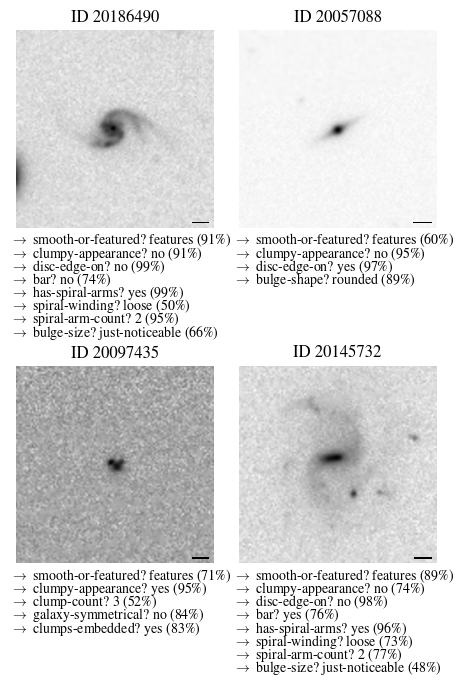

In [ ]:
#Plot
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(6,7))
fig.tight_layout(pad=5)
ax = ax.flatten()
for i in range(len(ax)):

    image_size = float(3*metadata[metadata["survey_id"]==int(image_ids[i].split(".")[0])]["KRON_RADIUS_HI"])
    resolution = image_size/300

    scalebar = ScaleBar(resolution,units="''",dimension="angle",color="black",frameon=False,location="lower right",label_loc="none",scale_loc="none",fixed_value=1)

    im = ImageOps.invert(Image.open(path_images + image_ids[i]))
    ax[i].imshow(im)
    ax[i].axis("off")
    id = str(image_ids[i].split(".")[0])
    ax[i].set_title("ID "+ id)
    ax[i].add_artist(scalebar)

    data_row = data[data["id_str"]==path_images+image_ids[i]]

    asked_questions, given_answers, given_answers_frac = get_asked_questions(data_row,hubble_schema)
    for j in range(len(given_answers)):
        answer_text = given_answers[j].replace("-hubble","").replace("-larger-object","").replace("disk","disc")
        text = "$\\rightarrow$ {}? {} ({:.0%})".format(answer_text.split("_")[0],answer_text.split("_")[1],given_answers_frac[j])
        ax[i].text(-10,325+20*j,text)
fig.subplots_adjust(wspace=0.1,hspace=0.7)
plt.savefig("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/plots/example_detections.pdf",bbox_inches='tight')

### Examples with most confident answers

In [ ]:
def show_results_highest_conf(answers,answers_text,path_images,save_path_csv,save_path):
    data = pd.read_csv(save_path_csv)
    fig, ax = plt.subplots(nrows=len(answers), ncols=4,figsize=(9,14))
    for j in range(len(answers)):
        data_sorted = data.sort_values(answers[j]+"_pred_frac",ascending=False)
        ids = data_sorted["id_str"].to_numpy()
        conf = data_sorted[answers[j]+"_pred_frac"].to_numpy()
        for i in range(len(ax[j])):
            id = ids[i].split("/")[-1]
            confidence = conf[i]
            img = np.array(ImageOps.invert(Image.open((path_images+id))))
            image_size = float(3*metadata[metadata["survey_id"]==int(id.split(".")[0])]["KRON_RADIUS_HI"])
            resolution = image_size/300
            scalebar = ScaleBar(resolution,units="''",dimension="angle",color="black",frameon=False,location="lower right",label_loc="none",scale_loc="none",fixed_value=1)
            ax[j,i].imshow(img)
            ax[j,i].axis('off')
            ax[j,i].set_title("ID {} - {:.2%}".format(id.split("_")[-1].split(".")[0],confidence))
            ax[j,i].add_artist(scalebar)
        ax[j,1].text(305,350,answers_text[j],fontsize='xx-large',horizontalalignment='center')
    plt.savefig(save_path,bbox_inches='tight')

save_path_csv = "/content/drive/MyDrive/MPE/ZoobotEuclid/Results/euclid/complete/weights_B/num_galaxies_60940/test_predictions.csv"
path_images = "/content/jpgs_euclid_complete/"

<ipython-input-87-674a0498c4b8>:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  image_size = float(3*metadata[metadata["survey_id"]==int(id.split(".")[0])]["KRON_RADIUS_HI"])


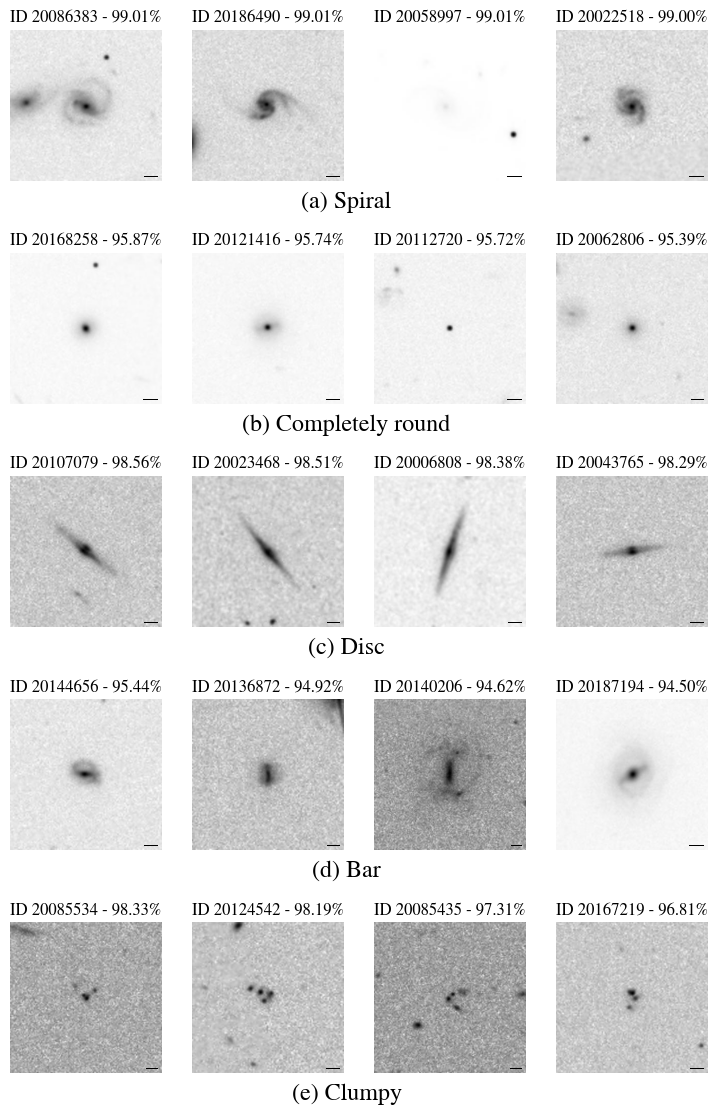

In [ ]:
answers = ["has-spiral-arms-hubble_yes","how-rounded-hubble_completely","disk-edge-on-hubble_yes","bar-hubble_yes","clumpy-appearance-hubble_yes"]
answers_text = ["(a) Spiral","(b) Completely round","(c) Disc","(d) Bar","(e) Clumpy"]
save_path = "/content/drive/MyDrive/MPE/ZoobotEuclid/Results/plots/euclid_max_pred_examples.pdf"
show_results_highest_conf(answers,answers_text,path_images,save_path_csv,save_path)

### Confusion matrices

In [ ]:
def get_confusion_matrix(schema, question, save_path, save_name, confident=False, ax=None, blank_yticks=False, add_title=False, normalize=False):

    data = pd.read_csv(save_path+save_name)
    answers = hubble_schema.question_answer_pairs[question]

    #Get number of volunteers
    number_votes = data["smooth-or-featured-hubble_number"]
    half_num_votes = np.array(number_votes)/2

    labels, predictions = [], []
    #count = 1
    for i in range(len(data)):
        if data[question+"_number"].iloc[i] >= half_num_votes[i]:
            frac_label, frac_pred = [],[]
            for j in range(len(answers)):
                frac_pred.append(data[question+answers[j]+"_pred_frac"].iloc[i])
                frac_label.append(data[question+answers[j]+"_frac"].iloc[i])
            if confident:
                if np.max(frac_label) > 0.8:
                    labels.append(np.argmax(frac_label))
                    predictions.append(np.argmax(frac_pred))
            else:
                predictions.append(np.argmax(frac_pred))
                labels.append(np.argmax(frac_label))

    class_indices = np.arange(0,len(answers))

    cm = metrics.confusion_matrix(labels, predictions,labels=class_indices, normalize="true").transpose()
    cm_abs = metrics.confusion_matrix(labels, predictions,labels=class_indices, normalize=None).transpose()

    print('{} & {} & {:.3f} & {:.3f} & {:.3f} & {:.3f} & {:.3f} \\\\'.format(
            question.replace("-hubble",""),
            len(labels),
            metrics.accuracy_score(labels, predictions),
            metrics.precision_score(labels, predictions, average="macro"),
            metrics.recall_score(labels, predictions, average="macro"),
            metrics.f1_score(labels, predictions, average="macro"),
            metrics.f1_score(labels, predictions, average="weighted")
        ))

    ticklabels = [answer.split("_")[1].replace('just-noticeable','noticeable') for answer in answers]

    return cm, ticklabels, cm_abs

In [ ]:
def plot_confusion_matrices(schema,question_list,save_path,save_name,save_path_plot,confident):
    fig, ax = plt.subplots(nrows=3, ncols=5,figsize=(14,9))
    fig.tight_layout(pad=2)
    ax = ax.flatten()
    for i in range(len(question_list)):
        cm, ticklabels, cm_abs = get_confusion_matrix(schema,question_list[i],save_path,save_name,confident=confident)
        labels = []
        for j in range(len(cm)):
            labels_row = []
            for k in range(len(cm[j])):
                label = "{:.1%}".format(cm[j,k])+"\n"+"({})".format(cm_abs[j,k])
                labels_row.append(label)
            labels.append(labels_row)
        sns.heatmap(cm, annot=labels,cmap='Blues',fmt="",xticklabels=ticklabels,yticklabels=ticklabels,cbar=False,ax=ax[i],square=True,robust=True)
        ax[i].set_title(question_list[i].replace("-hubble",""),weight='bold')
        ax[i].text(0.5,-0.15, 'True', horizontalalignment='center', verticalalignment='center',transform = ax[i].transAxes,weight='bold')
        ax[i].text(-0.15,0.5, 'Predicted', rotation='vertical', horizontalalignment='center', verticalalignment='center',transform = ax[i].transAxes,weight='bold')
    fig.delaxes(ax[13])
    fig.delaxes(ax[14])
    plt.savefig(save_path_plot,bbox_inches='tight')

smooth-or-featured & 15236 & 0.885 & 0.835 & 0.811 & 0.822 & 0.884 \\
disk-edge-on & 986 & 0.982 & 0.963 & 0.957 & 0.960 & 0.982 \\
has-spiral-arms & 764 & 0.916 & 0.584 & 0.725 & 0.614 & 0.935 \\
bar & 974 & 0.878 & 0.822 & 0.744 & 0.774 & 0.869 \\
bulge-size & 975 & 0.822 & 0.542 & 0.563 & 0.549 & 0.823 \\
how-rounded & 9915 & 0.874 & 0.872 & 0.868 & 0.869 & 0.874 \\
bulge-shape & 84 & 0.893 & 0.866 & 0.875 & 0.870 & 0.894 \\
spiral-winding & 746 & 0.709 & 0.683 & 0.672 & 0.677 & 0.709 \\
spiral-arm-count & 745 & 0.678 & 0.450 & 0.353 & 0.375 & 0.653 \\
clumpy-appearance & 2265 & 0.874 & 0.867 & 0.850 & 0.857 & 0.873 \\
clump-count & 328 & 0.546 & 0.516 & 0.413 & 0.390 & 0.539 \\
galaxy-symmetrical & 225 & 0.880 & 0.884 & 0.690 & 0.737 & 0.860 \\
clumps-embedded-larger-object & 226 & 0.850 & 0.791 & 0.819 & 0.803 & 0.853 \\


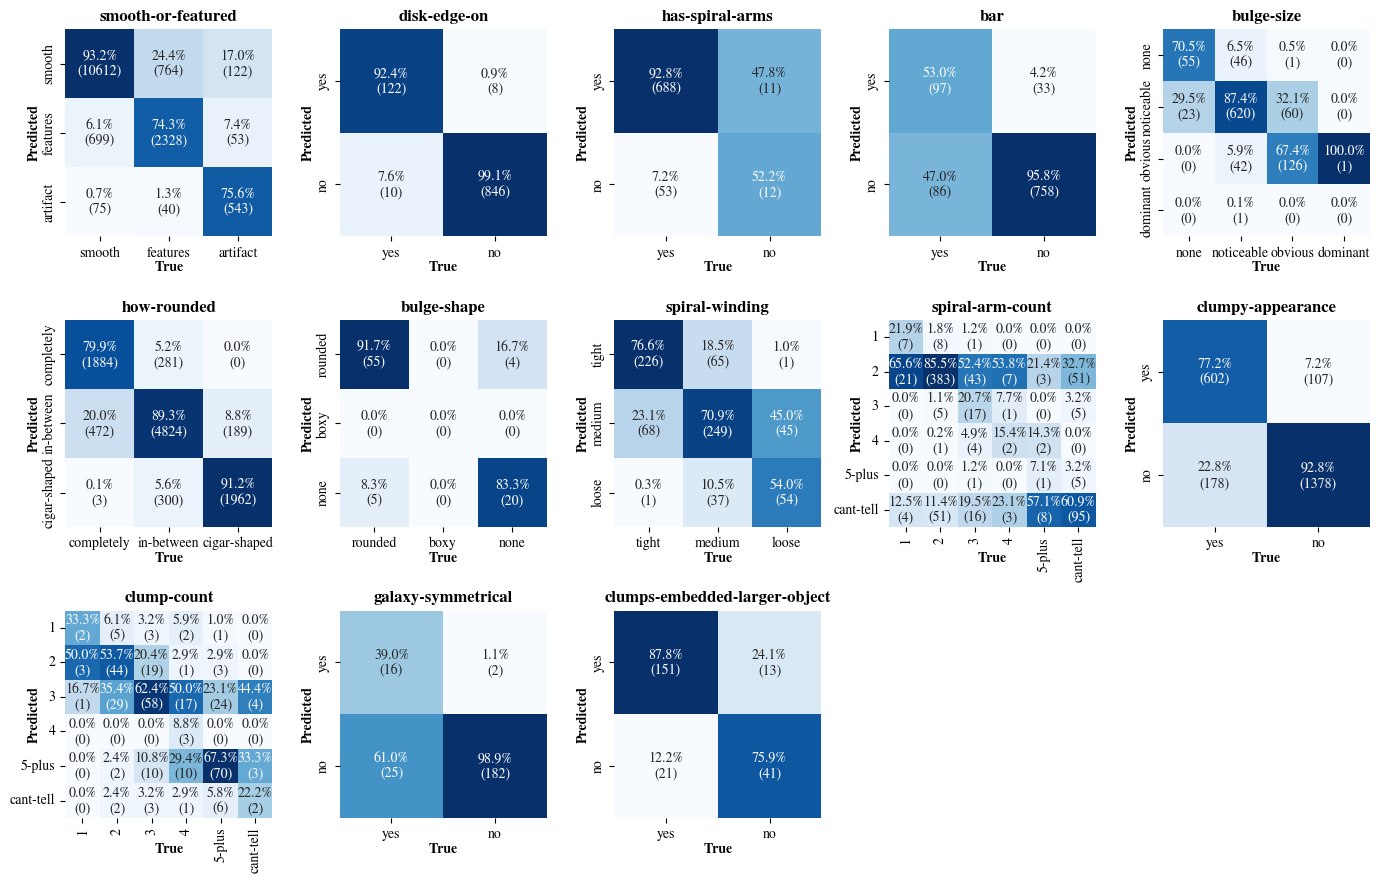

In [ ]:
#Euclid - Complete dataset, weights B
save_path_euclid = "/content/drive/MyDrive/MPE/ZoobotEuclid/Results/euclid/complete/weights_B/num_galaxies_60940/"
save_path_plot = "/content/drive/MyDrive/MPE/ZoobotEuclid/Results/plots/confusion_matrices_euclid_complete_full.pdf"
question_list = ['smooth-or-featured-hubble','disk-edge-on-hubble', 'has-spiral-arms-hubble','bar-hubble','bulge-size-hubble',\
    'how-rounded-hubble','bulge-shape-hubble','spiral-winding-hubble','spiral-arm-count-hubble','clumpy-appearance-hubble',\
    'clump-count-hubble','galaxy-symmetrical-hubble','clumps-embedded-larger-object-hubble']
plot_confusion_matrices(hubble_schema,question_list,save_path_euclid,"test_predictions.csv",save_path_plot,confident=False)

smooth-or-featured & 1963 & 0.995 & 0.995 & 0.993 & 0.994 & 0.995 \\
disk-edge-on & 907 & 0.998 & 0.994 & 0.994 & 0.994 & 0.998 \\
has-spiral-arms & 666 & 0.950 & 0.542 & 0.975 & 0.564 & 0.971 \\
bar & 511 & 0.977 & 0.968 & 0.907 & 0.935 & 0.976 \\
bulge-size & 85 & 0.976 & 0.905 & 0.991 & 0.940 & 0.978 \\
how-rounded & 5119 & 0.979 & 0.979 & 0.977 & 0.978 & 0.979 \\
bulge-shape & 36 & 0.917 & 0.864 & 0.946 & 0.893 & 0.921 \\
spiral-winding & 46 & 0.978 & 0.933 & 0.982 & 0.954 & 0.979 \\


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


spiral-arm-count & 202 & 0.941 & 0.396 & 0.534 & 0.402 & 0.943 \\
clumpy-appearance & 1307 & 0.970 & 0.967 & 0.959 & 0.963 & 0.970 \\


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


clump-count & 64 & 0.828 & 0.540 & 0.513 & 0.525 & 0.868 \\
galaxy-symmetrical & 115 & 0.974 & 0.986 & 0.850 & 0.905 & 0.972 \\
clumps-embedded-larger-object & 85 & 0.941 & 0.844 & 0.966 & 0.890 & 0.946 \\


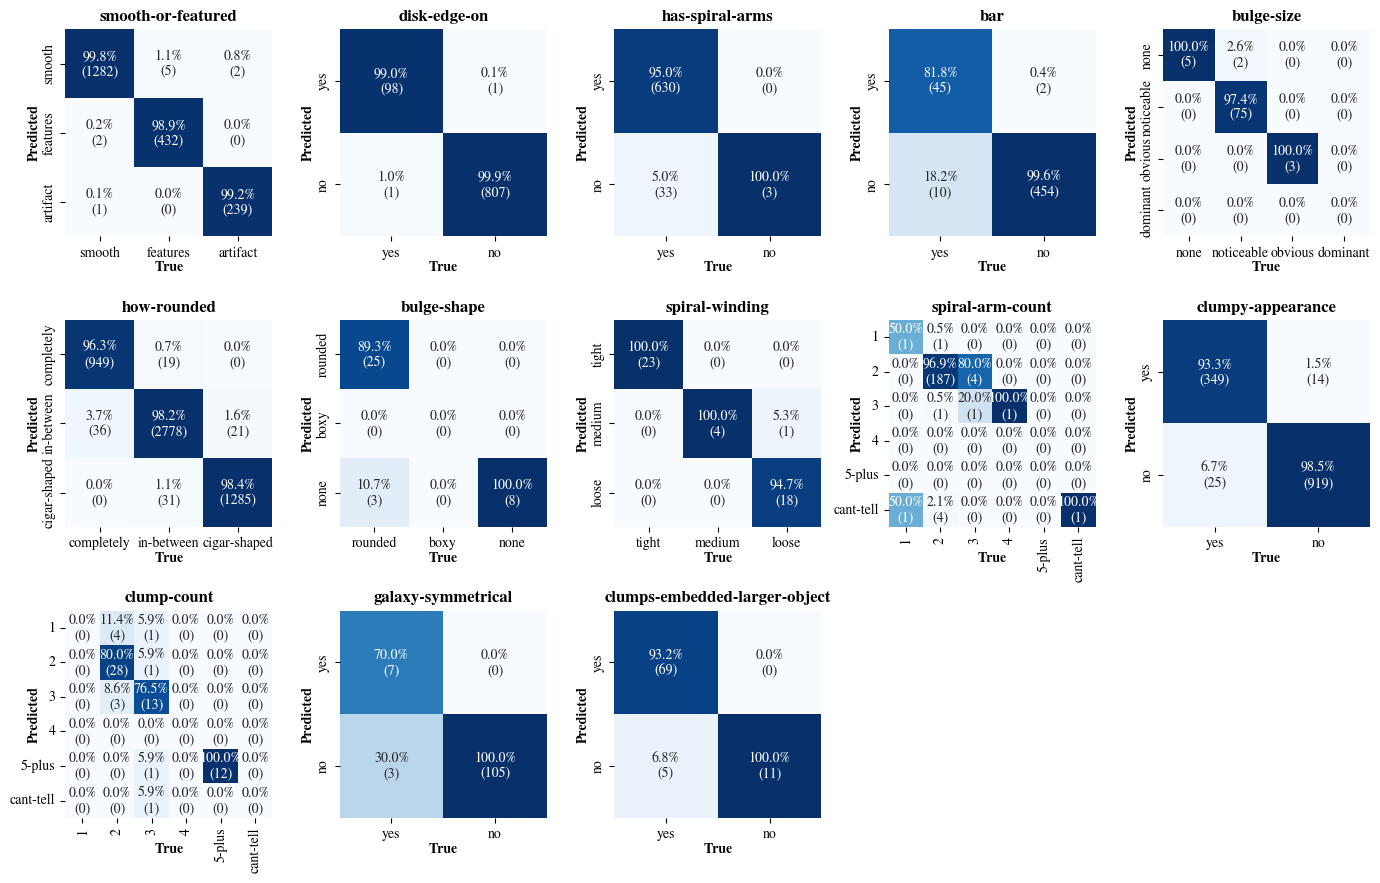

In [ ]:
save_path_plot = "/content/drive/MyDrive/MPE/ZoobotEuclid/Results/plots/confusion_matrices_euclid_complete_full_confident.pdf"
plot_confusion_matrices(hubble_schema,question_list,save_path_euclid,"test_predictions.csv",save_path_plot,confident=True)

In [ ]:
def get_labels(cm,cm_abs):
    labels = []
    for j in range(len(cm)):
        labels_row = []
        for k in range(len(cm[j])):
            if len(cm) >=4:
                label = "{:.1%}".format(cm[j,k])
            else:
                label = "{:.1%}".format(cm[j,k])+"\n"+"({})".format(cm_abs[j,k])
            labels_row.append(label)
        labels.append(labels_row)
    return labels

In [ ]:
#Show only some confusion matrices
def plot_confusion_matrices_selected(schema,question_list,save_path,save_name,save_path_plot):
    if len(question_list) == 5:
        fig, ax = plt.subplots(nrows=5, ncols=2,figsize=(5,10))
    else:
        fig, ax = plt.subplots(nrows=4, ncols=2,figsize=(6,12))
    fig.tight_layout(pad=2)
    for i in range(len(question_list)):
        #Not confident
        cm, ticklabels, cm_abs = get_confusion_matrix(schema,question_list[i],save_path,save_name,confident=False)
        labels = get_labels(cm,cm_abs)
        sns.heatmap(cm, annot=labels,cmap='Blues',fmt="",xticklabels=ticklabels,yticklabels=ticklabels,cbar=False,ax=ax[i,0],square=True,robust=True)
        ax[i,0].set_title(question_list[i].replace("-hubble","").replace("disk","disc"),weight='bold')
        ax[i,0].text(0.5,-0.04*len(question_list), 'True', horizontalalignment='center', verticalalignment='center',transform = ax[i,0].transAxes,weight='bold')
        ax[i,0].text(-0.04*len(question_list),0.5, 'Predicted', rotation='vertical', horizontalalignment='center', verticalalignment='center',transform = ax[i,0].transAxes,weight='bold')
        #confident
        cm, ticklabels, cm_abs = get_confusion_matrix(schema,question_list[i],save_path,save_name,confident=True)
        labels = get_labels(cm,cm_abs)
        sns.heatmap(cm, annot=labels,cmap='Blues',fmt="",xticklabels=ticklabels,yticklabels=ticklabels,cbar=False,ax=ax[i,1],square=True,robust=True)
        ax[i,1].set_title(question_list[i].replace("-hubble","").replace("disk","disc"),weight='bold')
        ax[i,1].text(0.5,-0.04*len(question_list), 'True', horizontalalignment='center', verticalalignment='center',transform = ax[i,1].transAxes,weight='bold')
        ax[i,1].text(-0.04*len(question_list),0.5, 'Predicted', rotation='vertical', horizontalalignment='center', verticalalignment='center',transform = ax[i,1].transAxes,weight='bold')

    if len(question_list) == 5:
        factor = 1.4
    else:
        factor = 1.3
    ax[len(question_list)-1,0].text(len(ticklabels)/2,len(ticklabels)*factor,"(a) All galaxies",horizontalalignment='center',fontsize="large")
    ax[len(question_list)-1,1].text(len(ticklabels)/2,len(ticklabels)*factor+0.25,"(b) Galaxies with confident \n volunteer responses",horizontalalignment='center',fontsize="large")

    plt.savefig(save_path_plot,bbox_inches='tight')

smooth-or-featured & 15236 & 0.885 & 0.835 & 0.811 & 0.822 & 0.884 \\
smooth-or-featured & 1963 & 0.995 & 0.995 & 0.993 & 0.994 & 0.995 \\
disk-edge-on & 986 & 0.982 & 0.963 & 0.957 & 0.960 & 0.982 \\
disk-edge-on & 907 & 0.998 & 0.994 & 0.994 & 0.994 & 0.998 \\
has-spiral-arms & 764 & 0.916 & 0.584 & 0.725 & 0.614 & 0.935 \\
has-spiral-arms & 666 & 0.950 & 0.542 & 0.975 & 0.564 & 0.971 \\
bar & 974 & 0.878 & 0.822 & 0.744 & 0.774 & 0.869 \\
bar & 511 & 0.977 & 0.968 & 0.907 & 0.935 & 0.976 \\
clumpy-appearance & 2265 & 0.874 & 0.867 & 0.850 & 0.857 & 0.873 \\
clumpy-appearance & 1307 & 0.970 & 0.967 & 0.959 & 0.963 & 0.970 \\


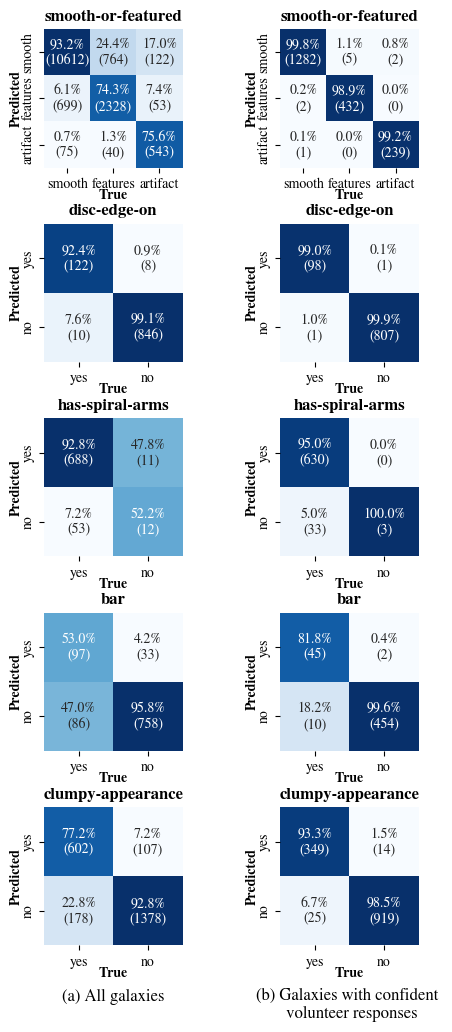

In [ ]:
#Euclid - Complete dataset, weights B
save_path_euclid = "/content/drive/MyDrive/MPE/ZoobotEuclid/Results/euclid/complete/weights_B/num_galaxies_60940/"
save_path_plot = "/content/drive/MyDrive/MPE/ZoobotEuclid/Results/plots/confusion_matrices_euclid_complete_selected.pdf"
question_list = ["smooth-or-featured-hubble","disk-edge-on-hubble","has-spiral-arms-hubble","bar-hubble","clumpy-appearance-hubble"]
plot_confusion_matrices_selected(hubble_schema,question_list,save_path_euclid,"test_predictions.csv",save_path_plot)

how-rounded & 9915 & 0.874 & 0.872 & 0.868 & 0.869 & 0.874 \\
how-rounded & 5119 & 0.979 & 0.979 & 0.977 & 0.978 & 0.979 \\
spiral-arm-count & 745 & 0.678 & 0.450 & 0.353 & 0.375 & 0.653 \\


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


spiral-arm-count & 202 & 0.941 & 0.396 & 0.534 & 0.402 & 0.943 \\
bulge-size & 975 & 0.822 & 0.542 & 0.563 & 0.549 & 0.823 \\
bulge-size & 85 & 0.976 & 0.905 & 0.991 & 0.940 & 0.978 \\
spiral-winding & 746 & 0.709 & 0.683 & 0.672 & 0.677 & 0.709 \\
spiral-winding & 46 & 0.978 & 0.933 & 0.982 & 0.954 & 0.979 \\


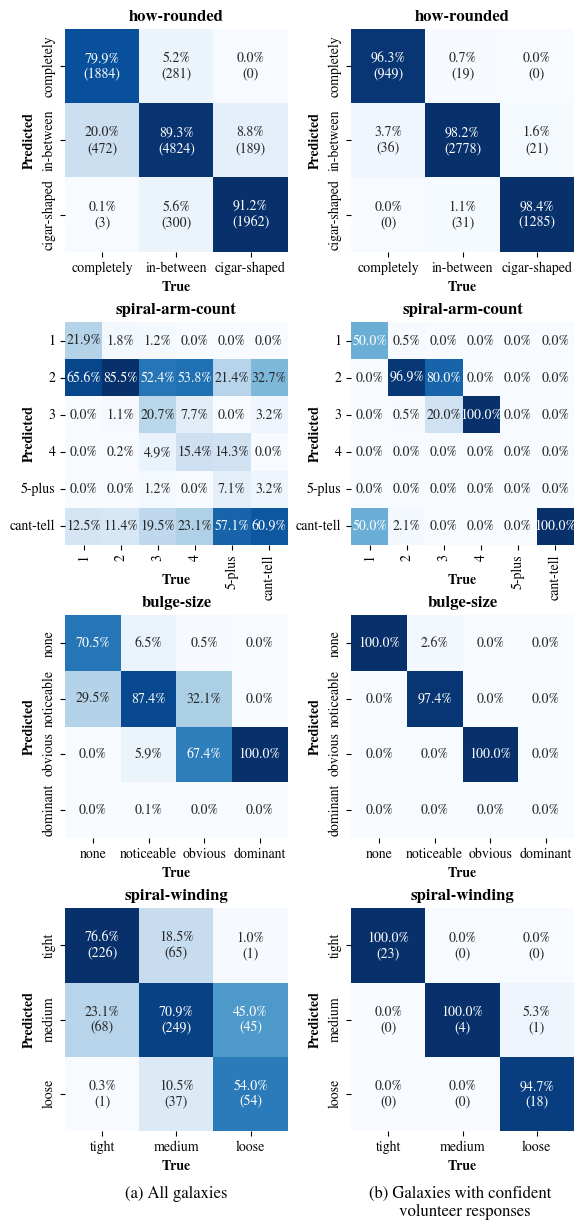

In [ ]:
#Euclid - Complete dataset, weights B
save_path_euclid = "/content/drive/MyDrive/MPE/ZoobotEuclid/Results/euclid/complete/weights_B/num_galaxies_60940/"
save_path_plot = "/content/drive/MyDrive/MPE/ZoobotEuclid/Results/plots/confusion_matrices_euclid_complete_selected2.pdf"
question_list = ["how-rounded-hubble","spiral-arm-count-hubble","bulge-size-hubble","spiral-winding-hubble"]
plot_confusion_matrices_selected(hubble_schema,question_list,save_path_euclid,"test_predictions.csv",save_path_plot)

bulge-shape & 84 & 0.893 & 0.866 & 0.875 & 0.870 & 0.894 \\
bulge-shape & 36 & 0.917 & 0.864 & 0.946 & 0.893 & 0.921 \\
clump-count & 328 & 0.546 & 0.516 & 0.413 & 0.390 & 0.539 \\


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


clump-count & 64 & 0.828 & 0.540 & 0.513 & 0.525 & 0.868 \\
galaxy-symmetrical & 225 & 0.880 & 0.884 & 0.690 & 0.737 & 0.860 \\
galaxy-symmetrical & 115 & 0.974 & 0.986 & 0.850 & 0.905 & 0.972 \\
clumps-embedded-larger-object & 226 & 0.850 & 0.791 & 0.819 & 0.803 & 0.853 \\
clumps-embedded-larger-object & 85 & 0.941 & 0.844 & 0.966 & 0.890 & 0.946 \\


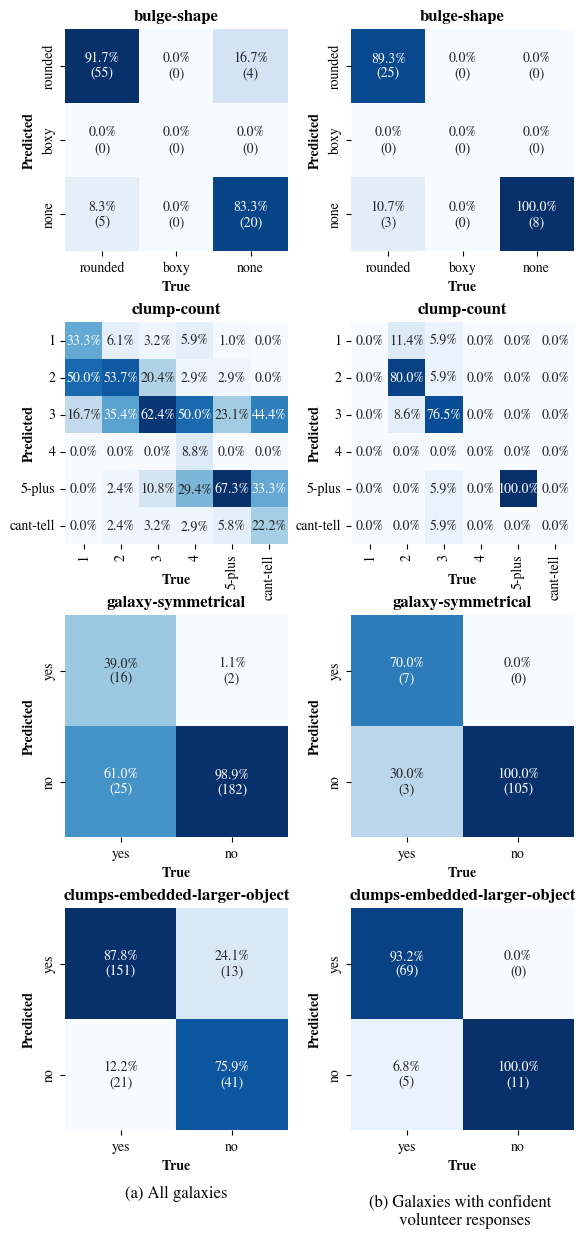

In [ ]:
#Euclid - Complete dataset, weights B
save_path_euclid = "/content/drive/MyDrive/MPE/ZoobotEuclid/Results/euclid/complete/weights_B/num_galaxies_60940/"
save_path_plot = "/content/drive/MyDrive/MPE/ZoobotEuclid/Results/plots/confusion_matrices_euclid_complete_selected3.pdf"
question_list = ["bulge-shape-hubble","clump-count-hubble","galaxy-symmetrical-hubble","clumps-embedded-larger-object-hubble"]
plot_confusion_matrices_selected(hubble_schema,question_list,save_path_euclid,"test_predictions.csv",save_path_plot)

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/euclid/complete/weights_B/num_galaxies_60940/test_predictions.csv")
data

id_str  \
0       /content/jpgs_euclid_complete/20000347.jpg   
1       /content/jpgs_euclid_complete/20000358.jpg   
2       /content/jpgs_euclid_complete/20000380.jpg   
3       /content/jpgs_euclid_complete/20000575.jpg   
4       /content/jpgs_euclid_complete/20000609.jpg   
...                                            ...   
15231  /content/jpgs_euclid_complete/201827042.jpg   
15232  /content/jpgs_euclid_complete/201858002.jpg   
15233  /content/jpgs_euclid_complete/201903062.jpg   
15234  /content/jpgs_euclid_complete/201989002.jpg   
15235  /content/jpgs_euclid_complete/202000022.jpg   

       smooth-or-featured-hubble_smooth_pred  \
0                                  85.137970   
1                                  44.269409   
2                                  22.051064   
3                                  75.336601   
4                                  53.105244   
...                                      ...   
15231                               6.205693   
15232                              20.720436   
15233                              17.663603   
15234                              34.521206   
15235                              54.074127   

       smooth-or-featured-hubble_features_pred  \
0                                    18.716059   
1                                    16.750996   
2                                    37.156700   
3                                    11.207593   
4                                    13.113345   
...                                        ...   
15231                                43.783257   
15232                                27.707628   
15233                                27.936218   
15234                                13.078482   
15235                                12.265894   

       smooth-or-featured-hubble_artifact_pred  disk-edge-on-hubble_yes_pred  \
0                                    12.987276                      1.051232   
1                                    16.590633                      1.689741   
2                                    20.623430                      1.941250   
3                                    12.208768                      1.020246   
4                                    11.615759                      3.324199   
...                                        ...                           ...   
15231                                 5.410901                      2.207753   
15232                                13.684562                      1.166209   
15233                                25.712259                      1.612935   
15234                                 7.662127                      1.199730   
15235                                14.007408                      1.030512   

       disk-edge-on-hubble_no_pred  has-spiral-arms-hubble_yes_pred  \
0                        37.215397                         1.075260   
1                        13.985270                         1.346392   
2                         7.762775                         1.128398   
3                        40.270794                         1.076014   
4                         4.883403                         1.327337   
...                            ...                              ...   
15231                    71.155411                        19.520979   
15232                    60.905945                         1.568711   
15233                    33.996662                         1.158329   
15234                    36.938381                         1.636162   
15235                    56.136490                         1.192115   

       has-spiral-arms-hubble_no_pred  bar-hubble_yes_pred  \
0                           11.935286             1.198963   
1                            5.968578             1.523418   
2                           26.241989             1.302428   
3                            6.997932             1.172357   
4                            9.717198             1.663701   
...                            

In [ ]:
def spiral_confusion_matrix(data,thresh_up,thresh_low):
    #Confusion matrix spiral
    labels_spiral, predictions_spiral = [], []
    for i in range(len(data)):
        #Labels
        if data["smooth-or-featured-hubble_features_frac"].iloc[i] <= 0.23:
            labels_spiral.append(0)
        else:
            if data["clumpy-appearance-hubble_no_frac"].iloc[i] <= 0.3:
                labels_spiral.append(0)
            else:
                if data["disk-edge-on-hubble_no_frac"].iloc[i] <= 0.25:
                    labels_spiral.append(0)
                else:
                    if data["has-spiral-arms-hubble_number"].iloc[i] >= 20 and data["has-spiral-arms-hubble_yes_frac"].iloc[i] > thresh_up:
                        labels_spiral.append(1)
                    elif data["has-spiral-arms-hubble_number"].iloc[i] >= 20 and data["has-spiral-arms-hubble_yes_frac"].iloc[i] < thresh_low:
                        labels_spiral.append(0)
                    else:
                        continue

        #Predictions
        if data["smooth-or-featured-hubble_features_pred_frac"].iloc[i] <= 0.23:
            predictions_spiral.append(0)
        else:
            if data["clumpy-appearance-hubble_no_pred_frac"].iloc[i] <= 0.3:
                predictions_spiral.append(0)
            else:
                if data["disk-edge-on-hubble_no_pred_frac"].iloc[i] <= 0.25:
                    predictions_spiral.append(0)
                else:
                    if data["has-spiral-arms-hubble_yes_pred_frac"].iloc[i] > 0.5:
                        predictions_spiral.append(1)
                    else:
                        predictions_spiral.append(0)

    cm = metrics.confusion_matrix(labels_spiral, predictions_spiral, normalize="true",labels=[1,0]).transpose()
    cm_abs = metrics.confusion_matrix(labels_spiral, predictions_spiral, normalize=None,labels=[1,0]).transpose()
    label_names = []
    for j in range(len(cm)):
        labels_row = []
        for k in range(len(cm[j])):
            label = "{:.1%}".format(cm[j,k])+"\n"+"({})".format(cm_abs[j,k])
            labels_row.append(label)
        label_names.append(labels_row)
    print('{} & {:.3f} & {:.3f} & {:.3f} & {:.3f} & {:.3f} \\\\'.format(
                len(labels_spiral),
                metrics.accuracy_score(labels_spiral, predictions_spiral),
                metrics.precision_score(labels_spiral, predictions_spiral, average="macro"),
                metrics.recall_score(labels_spiral, predictions_spiral, average="macro"),
                metrics.f1_score(labels_spiral, predictions_spiral, average="macro"),
                metrics.f1_score(labels_spiral, predictions_spiral, average="weighted")
            ))
    return cm, label_names

10746 & 0.965 & 0.864 & 0.936 & 0.896 & 0.966 \\
10553 & 0.970 & 0.859 & 0.952 & 0.899 & 0.971 \\


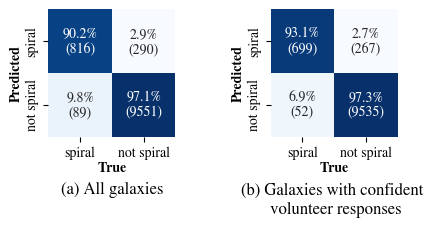

In [ ]:
cm_all, label_names_all = spiral_confusion_matrix(data,0.5,0.5)
cm_conf, label_names_conf = spiral_confusion_matrix(data,0.8,0.2)
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(5,2.75))
classes = ["spiral","not spiral"]
fig.tight_layout(pad=4)
ax[0].text(1,2.5, 'True', horizontalalignment='center', verticalalignment='center',weight='bold')
ax[0].text(-0.5,1, 'Predicted', rotation='vertical', horizontalalignment='center', verticalalignment='center',weight='bold')
ax[0].text(1,2.9, '(a) All galaxies', horizontalalignment='center', fontsize="large")
sns.heatmap(cm_all,annot=label_names_all,cmap='Blues',fmt="",xticklabels=classes,yticklabels=classes,ax=ax[0],cbar=False,square=True,robust=True)
ax[1].text(1,2.5, 'True', horizontalalignment='center', verticalalignment='center',weight='bold')
ax[1].text(-0.5,1, 'Predicted', rotation='vertical', horizontalalignment='center', verticalalignment='center',weight='bold')
ax[1].text(1,3.2, '(b) Galaxies with confident \n volunteer responses', horizontalalignment='center', fontsize="large")
sns.heatmap(cm_conf,annot=label_names_conf,cmap='Blues',fmt="",xticklabels=classes,yticklabels=classes,ax=ax[1],cbar=False,square=True,robust=True)
plt.savefig("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/plots/confusion_matrices_euclid_spiral.pdf",bbox_inches='tight')

### Vote fraction mean deviations

In [20]:
def mean_deviation_half(data,schema,confident=False,save_path_plot="mean_deviations.pdf",model_name="Zoobot - Euclid",show_plot=True):

    questions = list(schema.question_answer_pairs.keys())
    answers = schema.label_cols
    answer_indices = schema.question_index_groups

    #Get number of volunteers
    number_votes = data["smooth-or-featured-hubble_number"]
    half_num_votes = np.array(number_votes)/2

    #Calculate deviations
    deviations_answers, num_answers = [], []
    labels_complete, predictions_complete = [], []
    num_replies_answers = []
    deviations_all = []
    err_deviations_answers = []
    counter = 1
    for i in range(len(answers)):
        predictions, labels = [], []
        num_replies_answer = []
        question = answers[i].split("_")[0]
        for j in range(len(data)):
            if data[question+"_number"].iloc[j] >= half_num_votes[j]:
                if confident:
                    all_answers = [answer for answer in answers if question in answer]
                    fractions_answers, fractions_answers_pred = [], []
                    for k in range(len(all_answers)):
                        fractions_answers.append(data[all_answers[k]+"_frac"].iloc[j])
                        fractions_answers_pred.append(data[all_answers[k]+"_pred_frac"].iloc[j])
                    if np.max(fractions_answers) > 0.8:
                        predictions.append(data[answers[i]+"_pred_frac"].iloc[j])
                        labels.append(data[answers[i]+"_frac"].iloc[j])
                        num_replies_answer.append(data[question+"_number"].iloc[j])
                else:
                    predictions.append(data[answers[i]+"_pred_frac"].iloc[j])
                    labels.append(data[answers[i]+"_frac"].iloc[j])
                    num_replies_answer.append(data[question+"_number"].iloc[j])

        deviations = np.array(predictions)-np.array(labels)
        deviations_abs = np.abs(deviations)
        num_answers.append(len(deviations_abs))
        num_replies_answers.append(num_replies_answer)
        deviations_answers.append(np.mean(deviations_abs))
        err_deviations_answers.append(np.std(deviations_abs)/np.sqrt(len(deviations_abs)))
        deviations_all.append(deviations)
        labels_complete.append(labels)
        predictions_complete.append(predictions)

    if show_plot:
        plt.figure(figsize=(3,9))
        answers = [answer.replace("-hubble","") for answer in answers]
        for i in range(len(answer_indices)):
            plt.barh(answers[answer_indices[i][0]:answer_indices[i][1]+1],deviations_answers[answer_indices[i][0]:answer_indices[i][1]+1])
            plt.text(deviations_answers[answer_indices[i][0]:answer_indices[i][1]+1][0] + 0.002,\
                        answer_indices[i][0] + .2,str(num_answers[answer_indices[i][0]:answer_indices[i][1]+1][0]),fontsize="small",color="gray")
        plt.gca().invert_yaxis()
        plt.margins(0.01)
        plt.xlabel("Vote Fraction Mean Deviation")
        plt.grid(axis="x")
        plt.savefig(save_path_plot,bbox_inches='tight')
        plt.show()

    print("Average deviation:",np.mean(deviations_answers))

    return predictions_complete,labels_complete,deviations_answers,err_deviations_answers,num_answers,num_replies_answers,np.array(deviations_all)

In [ ]:
#Euclid - Complete dataset, weights B
save_path_plot = "/content/drive/MyDrive/MPE/ZoobotEuclid/Results/euclid/complete/weights_B/num_galaxies_60940/deviations.pdf"
data = pd.read_csv("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/euclid/complete/weights_B/num_galaxies_60940/test_predictions.csv")
pred_euclid_complete_B_complete, labels_complete_B_complete, deviations_euclid_complete_B_complete, err_deviations_euclid_complete_B_complete, num_answers_complete_B_complete,num_replies_answers_complete_B_complete,deviations_euclid_complete_B_complete_all = \
mean_deviation_half(data,hubble_schema,save_path_plot=save_path_plot,show_plot=True)

In [ ]:
#Different magnitudes
data_all = pd.read_csv("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/euclid/complete/weights_B/num_galaxies_60940/test_predictions.csv")
bins_mag = np.arange(17.5,24.5,1.5)
print(bins_mag)
deviations_euclid_mags = []
for i in range(len(bins_mag)-1):
    data_mag = data_all[(data_all["MAG_BEST_HI"]>bins_mag[i]) & (data_all["MAG_BEST_HI"]<bins_mag[i+1])]
    _,_, dev, _,_,_,_ = mean_deviation_half(data_mag,hubble_schema,show_plot=False)
    deviations_euclid_mags.append(dev)
_,_,deviations_euclid_all_mags, _,_,_,_ = mean_deviation_half(data_all,hubble_schema,show_plot=False)

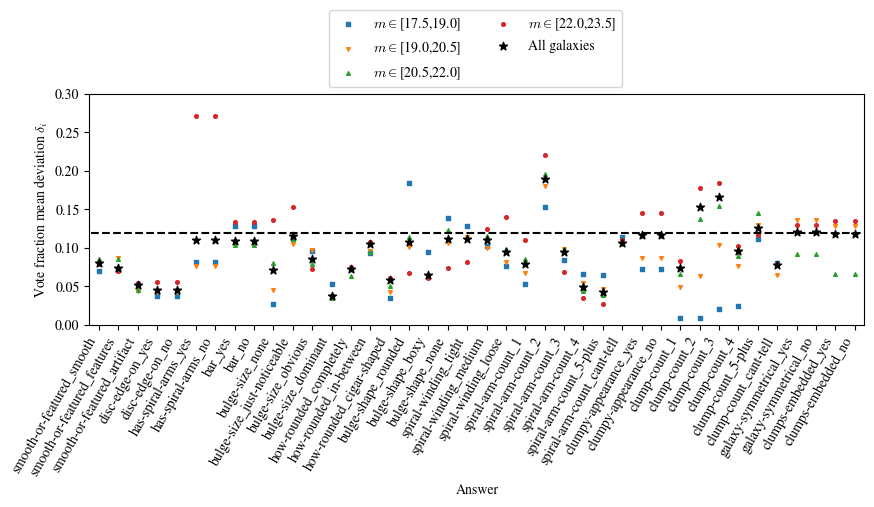

In [ ]:
#Scatter plot
questions_hubble = list(hubble_schema.question_answer_pairs.keys())
answers_hubble = hubble_schema.label_cols
answer_indices_hubble = hubble_schema.question_index_groups
answers_hubble = [answer.replace("-hubble","").replace("-larger-object","").replace("disk","disc") for answer in answers_hubble]

plt.figure(figsize=(10,3))

markers = ["s","v","^","o"]
for i in range(len(bins_mag)-1):
    plt.scatter(answers_hubble,deviations_euclid_mags[i],label="$m\in$[{:.1f},{:.1f}]".format(bins_mag[i],bins_mag[i+1]),marker=markers[i],s=7)
plt.scatter(answers_hubble,deviations_euclid_all_mags,label="All galaxies",marker="*",color="black")

plt.hlines(0.12,-1,len(answers_hubble)+1,linestyle="--",color="black")

#questions_sep = [-0.5,2.5,4.5,6.5,8.5,12.5,15.5,18.5,21.5,27.5,29.5,35.5,37.5,39.5]
#for i in range(len(questions_sep[:-1])):
#    plt.vlines(questions_sep[i+1],0.0,0.4,linewidth=1,color="grey")

plt.margins(0.01)
plt.xlabel("Answer")
plt.ylabel("Vote fraction mean deviation $\delta_i$")
#plt.grid(axis="y")
plt.xticks(rotation=60,ha='right')
plt.xlim(-0.5,len(answers_hubble)-0.5)
plt.ylim(0.0,0.3)
plt.legend(bbox_to_anchor=(0.3, 1), loc="lower left",ncol=2)
plt.savefig("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/plots/vote_fraction_deviations_scatter_mag.pdf",bbox_inches='tight')

### Correlation between uncertainty and $\delta_i$

smooth-or-featured_features


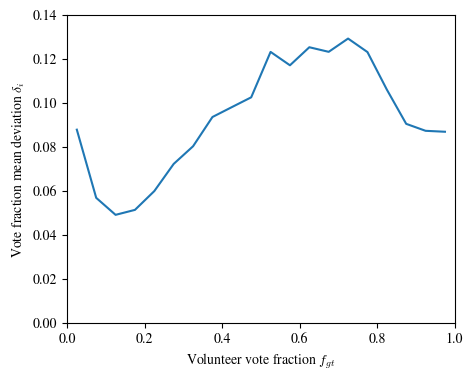

In [ ]:
#Show for features
plt.figure(figsize=(5,4))
index = 1
deltas, labels = [], []
bins = np.arange(0,1.05,0.05)
for j in range(len(labels_complete_B_complete[index])):
    label = labels_complete_B_complete[index][j]
    labels.append(label)
    prediction = pred_euclid_complete_B_complete[index][j]
    deviation = np.abs(label-prediction)
    deltas.append(deviation)

histo_deltas = stats.binned_statistic(labels, deltas, statistic='mean', bins=bins)
histo_deltas_std = stats.binned_statistic(labels, deltas, statistic='std', bins=bins)
histo_deltas_count = stats.binned_statistic(labels, deltas, statistic='count', bins=bins)
yerrs = histo_deltas_std[0]/np.sqrt(histo_deltas_count[0])

print(hubble_schema.label_cols[index].replace("-hubble",""))
plt.plot(bins[:-1]+0.5*(bins[1]-bins[0]),histo_deltas[0])
tops = histo_deltas[0] + yerrs
bottoms = histo_deltas[0] - yerrs
#plt.fill_between(bins[:-1]+0.5*(bins[1]-bins[0]), bottoms, tops, alpha=0.2)
plt.xlabel("Volunteer vote fraction $f_{gt}$")
plt.ylabel("Vote fraction mean deviation $\delta_i$")
plt.xlim(0,1)
plt.ylim(0,0.14)
plt.savefig("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/plots/vote_fraction_deviations_comp_sf.pdf",bbox_inches='tight')

### Histograms

0.06438412998441256
-0.30884506608633455
-0.5505375690192833
0.08324767445718001
-0.08324767445717869
-1.1530129282871766
1.1530129282871764
-0.7665305480896697
0.7665305480896699
-0.2521126121901576
0.25211261219015774


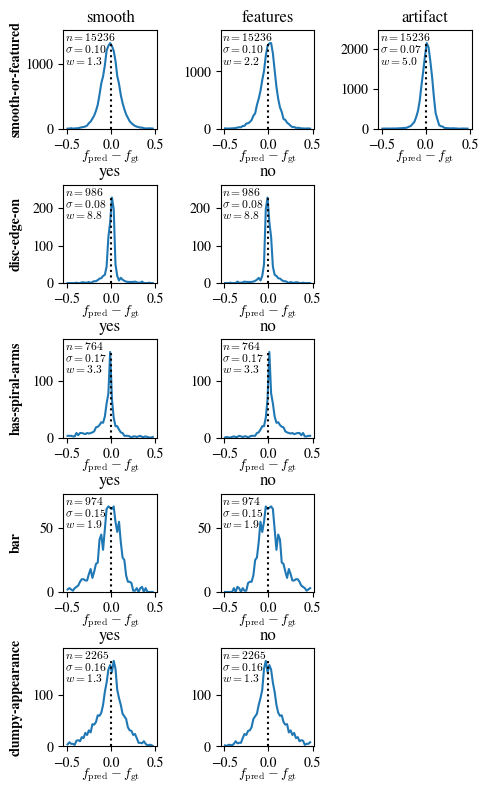

In [ ]:
#Histogram for vote fraction mean deviations
fig, ax = plt.subplots(nrows=5, ncols=3,figsize=(5,8))
fig.tight_layout(pad=2)
indices_answers = [[0,1,2],[3,4],[5,6],[7,8],[28,29]]
for i in range(len(indices_answers)):
    ax[i,0].text(-0.5,0.5, answers_hubble[indices_answers[i][0]].split("_")[0].replace("disk","disc"), rotation='vertical', horizontalalignment='center', verticalalignment='center',transform = ax[i,0].transAxes,weight='bold')
    for j in range(len(indices_answers[i])):
        bins = np.arange(-0.5,0.5,0.02)
        hist = np.histogram(deviations_euclid_complete_B_complete_all[indices_answers[i][j]],bins=bins)
        ax[i,j].plot(hist[1][:-1]+0.01,hist[0])
        ax[i,j].vlines(0,0,np.max(hist[0])*1.0,color="black",linestyle="dotted")
        ax[i,j].set_ylim(0,np.max(hist[0])*1.15)
        ax[i,j].set_title(answers_hubble[indices_answers[i][j]].split("_")[1])
        ax[i,j].text(-0.52,np.max(hist[0])*1.02,"$n={}$".format(len(deviations_euclid_complete_B_complete_all[indices_answers[i][j]])),fontsize="small")
        sigma = np.std(deviations_euclid_complete_B_complete_all[indices_answers[i][j]])
        kurtosis = stats.kurtosis(deviations_euclid_complete_B_complete_all[indices_answers[i][j]])
        skewness = stats.skew(deviations_euclid_complete_B_complete_all[indices_answers[i][j]])
        print(skewness)
        ax[i,j].text(-0.52,np.max(hist[0])*0.88,"$\sigma={:.2f}$".format(sigma),fontsize="small")
        ax[i,j].text(-0.52,np.max(hist[0])*0.75,"$w={:.1f}$".format(kurtosis),fontsize="small")
        ax[i,j].set_xlabel("$f_{\mathrm{pred}}-f_{\mathrm{gt}}$",labelpad=-2)
fig.delaxes(ax[1,2])
fig.delaxes(ax[2,2])
fig.delaxes(ax[3,2])
fig.delaxes(ax[4,2])
plt.savefig("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/plots/histograms_deviations_selected.pdf",bbox_inches='tight')
plt.show()

### Influence of number of training galaxies for the different answers

In [ ]:
#Complete training set, initial weights B
num_galaxies_complete_B = [5,10,20,50,100,200,500,1000,2000,5000,10000,20000,60940]
save_path_euclid = "/content/drive/MyDrive/MPE/ZoobotEuclid/Results/euclid/complete/weights_B/num_galaxies_"
answer_indices = hubble_schema.question_index_groups
deviations_complete_B = []
for i in range(len(num_galaxies_complete_B)):
    data = pd.read_csv(save_path_euclid+str(num_galaxies_complete_B[i])+"/test_predictions.csv")
    _,_,deviation, _, _, _, _ = mean_deviation_half(data,hubble_schema,show_plot=False)
    deviations_questions = []
    for j in range(len(answer_indices)):
        deviations_questions.append(np.mean(deviation[answer_indices[j][0]:answer_indices[j][1]+1]))
    deviations_complete_B.append(deviations_questions)
deviations_complete_B = np.array(deviations_complete_B)

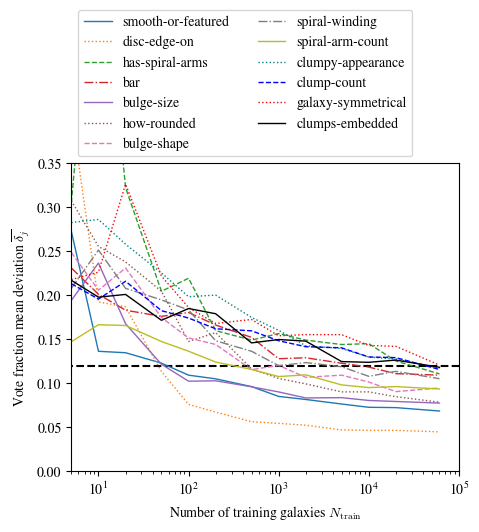

In [ ]:
#Compare answers
plt.figure(figsize=(5,4))
colors = list(mcolors.TABLEAU_COLORS.keys())[:-1] + ["teal","b","r","k"]
linestyles = ["solid","dotted","dashed","dashdot","solid","dotted","dashed","dashdot","solid","dotted","dashed","dotted","solid"]
questions = list(hubble_schema.question_answer_pairs.keys())
plt.hlines(0.12,-1,1e5,linestyle="--",color="black")
for i in range(len(questions)):
    plt.plot(num_galaxies_complete_B,deviations_complete_B[:,i],label=questions[i].replace("-hubble","").replace("-larger-object","").replace("disk","disc"),color=colors[i],linewidth=1,linestyle=linestyles[i])
plt.xscale("log")
plt.xlabel("Number of training galaxies $N_{\mathrm{train}}$")
plt.ylabel("Vote fraction mean deviation $\overline{\delta_j}$")
plt.ylim(0,0.35)
#plt.grid()
plt.xlim(5,1e5)
plt.legend(bbox_to_anchor=(0, 1), loc="lower left",ncol=2)
plt.savefig("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/plots/num_galaxies_deviations_questions.pdf",bbox_inches='tight')

## Comparison between different models (Euclid)

### Different weights and datasets

Comparison between complete training set models.

In [ ]:
num_galaxies = 1000

In [ ]:
#Complete dataset, weights A
data = pd.read_csv("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/euclid/complete/weights_A/num_galaxies_{}/test_predictions.csv".format(num_galaxies))
_, _, deviations_euclid_complete_A,_, _, _, _ = mean_deviation_half(data,hubble_schema,show_plot=False)
print(deviations_euclid_complete_A)

#Complete dataset, weights B
data = pd.read_csv("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/euclid/complete/weights_B/num_galaxies_{}/test_predictions.csv".format(num_galaxies))
_, _, deviations_euclid_complete_B,_, _, _, _ = mean_deviation_half(data,hubble_schema,show_plot=False)
print(deviations_euclid_complete_B)

#Complete dataset, weights C
data = pd.read_csv("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/euclid/complete/weights_C/num_galaxies_{}/test_predictions.csv".format(num_galaxies))
_, _, deviations_euclid_complete_C,_, _, _, _ = mean_deviation_half(data,hubble_schema,show_plot=False)
print(deviations_euclid_complete_C)

#Bright dataset, weights A
data = pd.read_csv("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/euclid/bright/weights_A/num_galaxies_{}/test_predictions.csv".format(num_galaxies))
_, _, deviations_euclid_bright_A,_, _, _, _ = mean_deviation_half(data,hubble_schema,show_plot=False)
print(deviations_euclid_bright_A)

#Bright dataset, weights B
data = pd.read_csv("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/euclid/bright/weights_B/num_galaxies_{}/test_predictions.csv".format(num_galaxies))
_, _, deviations_euclid_bright_B,_, _, _, _ = mean_deviation_half(data,hubble_schema,show_plot=False)
print(deviations_euclid_bright_B)

#Bright dataset, weights C
data = pd.read_csv("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/euclid/bright/weights_C/num_galaxies_{}/test_predictions.csv".format(num_galaxies))
_, _, deviations_euclid_bright_C,_, _, _, _ = mean_deviation_half(data,hubble_schema,show_plot=False)
print(deviations_euclid_bright_C)

Average deviation: 0.13284609079342494
[0.1111441127794384, 0.09981436977912204, 0.06890773262722925, 0.06672251673567373, 0.06672251673567374, 0.21144076574909831, 0.21144076574909831, 0.13722121370450296, 0.13722121370450296, 0.10278720455993773, 0.14241653857410233, 0.10219007107666644, 0.044451573402856645, 0.11667040285174864, 0.14973346050750777, 0.09227873512499339, 0.1912284488704174, 0.07770666174790056, 0.1929217893621908, 0.14874606709758406, 0.12779629514540813, 0.11783726821080609, 0.08150060342274908, 0.2359121950499499, 0.12147346843539336, 0.054420245013322315, 0.04692401167023529, 0.13538531473424664, 0.1750060311396536, 0.1750060311396536, 0.12839020136850318, 0.21735519269082754, 0.1848629205979885, 0.1133466723454067, 0.17911119973881012, 0.1141355598524647, 0.1692905975385359, 0.16929059753853584, 0.14751653268213089, 0.14751653268213089]


<ipython-input-10-def17aa3974e>:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return predictions_complete,labels_complete,deviations_answers,err_deviations_answers,num_answers,num_replies_answers,np.array(deviations_all)


Average deviation: 0.12003103841663057
[0.10210872447815846, 0.09118620830982878, 0.06239280624709291, 0.05458329506319152, 0.054583295063191525, 0.1566475085252299, 0.1566475085252299, 0.12808964975889403, 0.12808964975889403, 0.09070609169293498, 0.13076674589369766, 0.10153000512658805, 0.03831168742742481, 0.09988685465329025, 0.13699349902065228, 0.08007914714372168, 0.13558527780039004, 0.07170369383843815, 0.15430303588144978, 0.1295872524624585, 0.13111229128545335, 0.0997514746322531, 0.07990239487737134, 0.22327636173827523, 0.10867048251394444, 0.05349804723185088, 0.04326435981311403, 0.13823485637910474, 0.16030569289761906, 0.16030569289761906, 0.10336188988893937, 0.20416391288774233, 0.18720785774337587, 0.11577947336466314, 0.171240322482084, 0.10933817335917673, 0.1541232257816374, 0.1541232257816374, 0.14989993221930192, 0.14989993221930192]


<ipython-input-10-def17aa3974e>:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return predictions_complete,labels_complete,deviations_answers,err_deviations_answers,num_answers,num_replies_answers,np.array(deviations_all)


Average deviation: 0.21249242021315054
[0.18447583439200751, 0.1541411460020432, 0.09714546980160033, 0.2544984018005846, 0.25449840180058464, 0.5418556549690917, 0.5418556549690917, 0.1860059274597559, 0.1860059274597559, 0.19039307009662648, 0.24394511254011042, 0.146904664602496, 0.11680830508502796, 0.26530555219775237, 0.29255733845930776, 0.29641521195043535, 0.2805341191033839, 0.07873404988724265, 0.29676405204900963, 0.20721253445589966, 0.14045722642208763, 0.17948601066381978, 0.10514750722755728, 0.3069370566713527, 0.11340495810163521, 0.07466211236011967, 0.07515639869242774, 0.1872415080980426, 0.27005937970219773, 0.27005937970219773, 0.22318634016089342, 0.22704491809145189, 0.1953810872951308, 0.11593643741365164, 0.2123360762162639, 0.11302679385473612, 0.25543099884485515, 0.25543099884485515, 0.18162759554046873, 0.1816275955404687]


<ipython-input-10-def17aa3974e>:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return predictions_complete,labels_complete,deviations_answers,err_deviations_answers,num_answers,num_replies_answers,np.array(deviations_all)


Average deviation: 0.1345031988971655
[0.1378302809877089, 0.12687732823676695, 0.07232348338217366, 0.06926430109438302, 0.06926430109438302, 0.15735193654432986, 0.15735193654432986, 0.12916066299443069, 0.12916066299443069, 0.09062602509137845, 0.13953800326214483, 0.10817388219840597, 0.04893064857430023, 0.14088844347591972, 0.1786136835754638, 0.12725669668058007, 0.15142902457262927, 0.07780772798837249, 0.1719140412951958, 0.14121788281453415, 0.12385647355243695, 0.10987717487514301, 0.08727137597636701, 0.24038738957976197, 0.11134407440932236, 0.06731483400954182, 0.0625673276086905, 0.12554378214535028, 0.19204837539982098, 0.19204837539982095, 0.13075173877678997, 0.2123088681582497, 0.18386564051857607, 0.11292188556436018, 0.17159534757768313, 0.11993473634814002, 0.1829621819458316, 0.1829621819458316, 0.17279261934652, 0.17279261934652]


<ipython-input-10-def17aa3974e>:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return predictions_complete,labels_complete,deviations_answers,err_deviations_answers,num_answers,num_replies_answers,np.array(deviations_all)


Average deviation: 0.12285050306231685
[0.11485336578075217, 0.10450588683496549, 0.06564114890218087, 0.059694443764315624, 0.05969444376431563, 0.13307267672889736, 0.13307267672889736, 0.1253567991773637, 0.1253567991773637, 0.07624176148489056, 0.1257927425769844, 0.09837495274880474, 0.04284024563792426, 0.1180018063434583, 0.1523473664214224, 0.09153739554979437, 0.1430451846480765, 0.07603386051563074, 0.15241535617238636, 0.1299699085769418, 0.12561723600621041, 0.10782225942816172, 0.07966017909548014, 0.22345658421974082, 0.11070913168721619, 0.05944830341960856, 0.05400563186081976, 0.12219343176522984, 0.1765449340203451, 0.1765449340203451, 0.11468874420881832, 0.21109703779801245, 0.18838398854863164, 0.11303533465890284, 0.1689715087793307, 0.0978611457289835, 0.16607924669744226, 0.16607924669744226, 0.16198621115829295, 0.16198621115829295]


<ipython-input-10-def17aa3974e>:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return predictions_complete,labels_complete,deviations_answers,err_deviations_answers,num_answers,num_replies_answers,np.array(deviations_all)


Average deviation: 0.1968374468893951
[0.17583421531045512, 0.14739452274784492, 0.08717285006232944, 0.26613423675320075, 0.26613423675320075, 0.4532662900431444, 0.4532662900431444, 0.1869562558973643, 0.1869562558973643, 0.12855261133553256, 0.1696550328685131, 0.1310876298213024, 0.07369453240921285, 0.2681293987982561, 0.2954417874188698, 0.30005996202869006, 0.19580961026446297, 0.07213048006743629, 0.21367409646943186, 0.20609557482517055, 0.14648633775537404, 0.15321630138716213, 0.09653800285989768, 0.29607250851042183, 0.11159549610935848, 0.07239250324843605, 0.0731251409729274, 0.1772276196417813, 0.24610885774961788, 0.24610885774961788, 0.2350043248902223, 0.21504775150952757, 0.1966530808293839, 0.11222750191475599, 0.1951217509840028, 0.1135149831674387, 0.27449113126080016, 0.27449113126080016, 0.18031436197967568, 0.1803143619796757]


<ipython-input-10-def17aa3974e>:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return predictions_complete,labels_complete,deviations_answers,err_deviations_answers,num_answers,num_replies_answers,np.array(deviations_all)


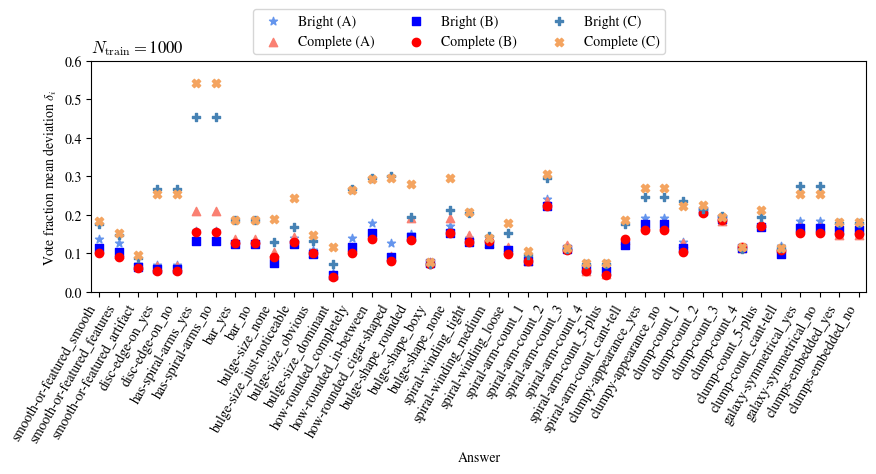

In [ ]:
#Scatter plot
#Predictions on bright and complete test set on one plot
questions_hubble = list(hubble_schema.question_answer_pairs.keys())
answers_hubble = hubble_schema.label_cols
answer_indices_hubble = hubble_schema.question_index_groups

answers_hubble = [answer.replace("-hubble","").replace("-larger-object","").replace("disk","disc") for answer in answers_hubble]

plt.figure(figsize=(10,3))
plt.scatter(answers_hubble,deviations_euclid_bright_A,label="Bright (A)",marker="*",color="cornflowerblue")
plt.scatter(answers_hubble,deviations_euclid_complete_A,label="Complete (A)",marker="^",color="salmon")
plt.scatter(answers_hubble,deviations_euclid_bright_B,label="Bright (B)",marker="s",color="blue")
plt.scatter(answers_hubble,deviations_euclid_complete_B,label="Complete (B)",marker="o",color="red")
plt.scatter(answers_hubble,deviations_euclid_bright_C,label="Bright (C)",marker="P",color="steelblue")
plt.scatter(answers_hubble,deviations_euclid_complete_C,label="Complete (C)",marker="X",color="sandybrown")

#questions_sep = [2.5,4.5,6.5,8.5,12.5,15.5,18.5,21.5,27.5,29.5,35.5,37.5]
#for i in range(len(questions_sep)):
#    plt.vlines(questions_sep[i],0.0,1,linewidth=1,color="grey")

plt.margins(0.01)
#plt.axvline(0, ls='-', color='black')
plt.xlabel("Answer")
plt.ylabel("Vote fraction mean deviation $\delta_i$")
#plt.grid(axis="y")
plt.xticks(rotation=60, ha='right')
plt.ylim(0,0.6)
#plt.ylim(0,0.3)
plt.title("$N_{\mathrm{train}}=$"+str(num_galaxies),loc='left')
plt.legend(bbox_to_anchor=(0.2, 1), loc="lower left",ncol=3)
plt.savefig("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/plots/deviations_datasets_weights_scatter_{}.pdf".format(str(num_galaxies)),bbox_inches='tight')
plt.show()

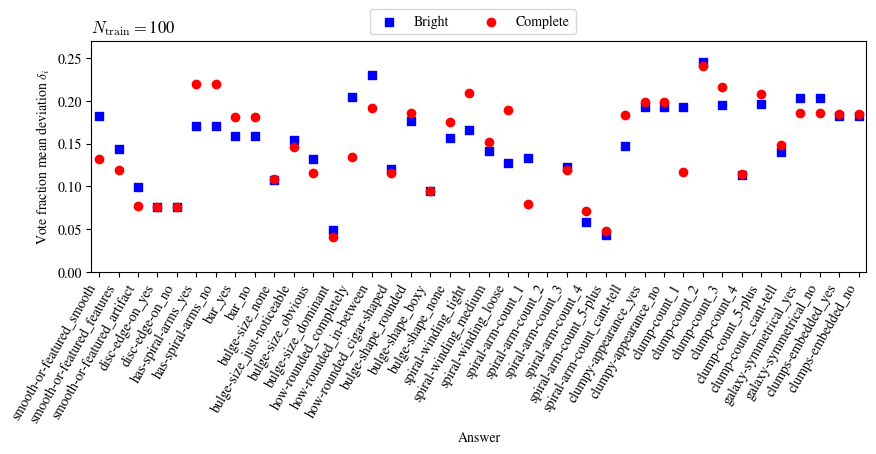

In [ ]:
#Scatter plot
#Predictions on bright and complete test set on one plot
questions_hubble = list(hubble_schema.question_answer_pairs.keys())
answers_hubble = hubble_schema.label_cols
answer_indices_hubble = hubble_schema.question_index_groups

answers_hubble = [answer.replace("-hubble","").replace("-larger-object","").replace("disk","disc") for answer in answers_hubble]

plt.figure(figsize=(10,3))
plt.scatter(answers_hubble,deviations_euclid_bright_B,label="Bright",marker="s",color="blue")
plt.scatter(answers_hubble,deviations_euclid_complete_B,label="Complete",marker="o",color="red")

#questions_sep = [2.5,4.5,6.5,8.5,12.5,15.5,18.5,21.5,27.5,29.5,35.5,37.5]
#for i in range(len(questions_sep)):
#    plt.vlines(questions_sep[i],0.0,1,linewidth=1,color="grey")

plt.margins(0.01)
plt.xlabel("Answer")
plt.ylabel("Vote fraction mean deviation $\delta_i$")
#plt.grid(axis="y")
plt.xticks(rotation=60, ha='right')
plt.ylim(0,0.27)
plt.title("$N_{\mathrm{train}}=$"+str(num_galaxies),loc='left')
plt.legend(bbox_to_anchor=(0.35, 1), loc="lower left",ncol=3)
plt.savefig("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/plots/deviations_datasets_weights_B_scatter_{}.pdf".format(str(num_galaxies)),bbox_inches='tight')
plt.show()

### Influence of number of training galaxies

In [ ]:
#Complete training set, initial weights B
num_galaxies_complete_B = [5,10,20,50,100,200,500,1000,2000,5000,10000,20000,60940]
save_path_euclid = "/content/drive/MyDrive/MPE/ZoobotEuclid/Results/euclid/complete/weights_B/num_galaxies_"
deviations_complete_avg_B = []
for i in range(len(num_galaxies_complete_B)):
    data = pd.read_csv(save_path_euclid+str(num_galaxies_complete_B[i])+"/test_predictions.csv")
    _,_,deviation, _, _, _, _ = mean_deviation_half(data,hubble_schema,show_plot=False)
    deviations_complete_avg_B.append(np.mean(deviation))

#Bright training set, initial weights B
num_galaxies_bright_B = [5,10,20,50,100,200,500,1000,2000,5000,10000,20000,27882]
save_path_euclid = "/content/drive/MyDrive/MPE/ZoobotEuclid/Results/euclid/bright/weights_B/num_galaxies_"
deviations_bright_avg_B = []
for i in range(len(num_galaxies_bright_B)):
    data = pd.read_csv(save_path_euclid+str(num_galaxies_bright_B[i])+"/test_predictions.csv")
    _,_,deviation, _, _, _, _ = mean_deviation_half(data,hubble_schema,show_plot=False)
    deviations_bright_avg_B.append(np.mean(deviation))

In [ ]:
#Bright training set, initial weights A
num_galaxies_bright_A = [5,10,20,50,100,200,500,1000,2000,5000,10000,20000,27882]
save_path_euclid = "/content/drive/MyDrive/MPE/ZoobotEuclid/Results/euclid/bright/weights_A/num_galaxies_"
deviations_bright_avg_A = []
for i in range(len(num_galaxies_bright_A)):
    data = pd.read_csv(save_path_euclid+str(num_galaxies_bright_A[i])+"/test_predictions.csv")
    _,_,deviation, _, _,  _, _ = mean_deviation_half(data,hubble_schema,show_plot=False)
    deviations_bright_avg_A.append(np.mean(deviation))

#Complete training set, initial weights A
num_galaxies_complete_A = [5,10,20,50,100,200,500,1000,2000,5000,10000,20000,60940]
save_path_euclid = "/content/drive/MyDrive/MPE/ZoobotEuclid/Results/euclid/complete/weights_A/num_galaxies_"
deviations_complete_avg_A = []
for i in range(len(num_galaxies_complete_A)):
    data = pd.read_csv(save_path_euclid+str(num_galaxies_complete_A[i])+"/test_predictions.csv")
    _,_,deviation, _, _,  _, _ = mean_deviation_half(data,hubble_schema,show_plot=False)
    deviations_complete_avg_A.append(np.mean(deviation))

#Complete training set, initial weights C
num_galaxies_complete_C = [5,10,20,50,100,200,500,1000,2000,5000,10000,20000,60940]
save_path_euclid = "/content/drive/MyDrive/MPE/ZoobotEuclid/Results/euclid/complete/weights_C/num_galaxies_"
deviations_complete_avg_C = []
for i in range(len(num_galaxies_complete_C)):
    data = pd.read_csv(save_path_euclid+str(num_galaxies_complete_C[i])+"/test_predictions.csv")
    _,_,deviation, _, _,  _, _ = mean_deviation_half(data,hubble_schema,show_plot=False)
    deviations_complete_avg_C.append(np.mean(deviation))

#Bright training set, initial weights C
num_galaxies_bright_C = [5,10,20,50,100,200,500,1000,2000,5000,10000,20000,27882]
save_path_euclid = "/content/drive/MyDrive/MPE/ZoobotEuclid/Results/euclid/bright/weights_C/num_galaxies_"
deviations_bright_avg_C = []
for i in range(len(num_galaxies_bright_C)):
    data = pd.read_csv(save_path_euclid+str(num_galaxies_bright_C[i])+"/test_predictions.csv")
    _,_,deviation, _, _,  _, _ = mean_deviation_half(data,hubble_schema,show_plot=False)
    deviations_bright_avg_C.append(np.mean(deviation))
print(deviations_bright_avg_C)

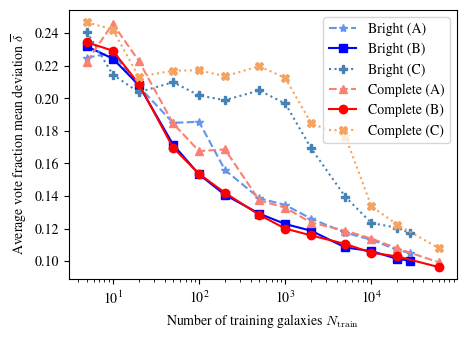

In [ ]:
#Compare models
plt.figure(figsize=(5,3.5))
plt.plot(num_galaxies_bright_A,deviations_bright_avg_A,marker="*",linestyle="--",color="cornflowerblue",label="Bright (A)")
plt.plot(num_galaxies_bright_B,deviations_bright_avg_B,marker="s",color="blue",label="Bright (B)")
plt.plot(num_galaxies_bright_C,deviations_bright_avg_C,marker="P",linestyle="dotted",color="steelblue",label="Bright (C)")

plt.plot(num_galaxies_complete_A,deviations_complete_avg_A,marker="^",linestyle="--",color="salmon",label="Complete (A)")
plt.plot(num_galaxies_complete_B,deviations_complete_avg_B,marker="o",color="red",label="Complete (B)")
plt.plot(num_galaxies_complete_C,deviations_complete_avg_C,marker="X",linestyle="dotted",color="sandybrown",label="Complete (C)")

plt.xscale("log")
plt.xlabel("Number of training galaxies $N_{\mathrm{train}}$")
plt.ylabel("Average vote fraction mean deviation $\overline{\delta}$")
plt.legend(loc="upper right")
#plt.yscale("log")
#plt.grid()
plt.savefig("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/plots/num_galaxies_deviations.pdf",bbox_inches='tight')

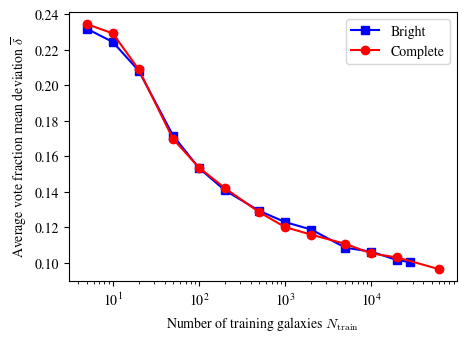

In [ ]:
#Compare models
plt.figure(figsize=(5,3.5))
plt.plot(num_galaxies_bright_B,deviations_bright_avg_B,marker="s",color="blue",label="Bright")
plt.plot(num_galaxies_complete_B,deviations_complete_avg_B,marker="o",color="red",label="Complete")

plt.xscale("log")
plt.xlabel("Number of training galaxies $N_{\mathrm{train}}$")
plt.ylabel("Average vote fraction mean deviation $\overline{\delta}$")
plt.legend(loc="upper right")
#plt.yscale("log")
#plt.grid()
plt.savefig("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/plots/num_galaxies_deviations_B.pdf",bbox_inches='tight')

## Comparison between Hubble and Euclid

In [ ]:
#Complete dataset, weights B
data = pd.read_csv("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/euclid/complete/weights_B/num_galaxies_60940/test_predictions.csv")
_,_, deviations_euclid_complete_B, _, _, _, _ = mean_deviation_half(data,hubble_schema,show_plot=False)

#Complete dataset, weights B
data = pd.read_csv("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/hubble/complete/weights_B/num_galaxies_60940/test_predictions.csv")
pred_hubble_complete_B_complete, labels_complete_B_complete, deviations_hubble_complete_B, _, _,_, deviations_hubble_complete_B_complete_all = mean_deviation_half(data,hubble_schema,show_plot=False)

data = pd.read_csv("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/hubble/complete/weights_B/num_galaxies_60940/test_predictions_euclid.csv")
_,_, deviations_hubble_complete_B_euclid, _, _,_, deviations_hubble_complete_B_complete_all_euclid = mean_deviation_half(data,hubble_schema,show_plot=False)

#data = pd.read_csv("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/hubble/complete/weights_B/num_galaxies_60940/test_predictions_hubble.csv")
#_,_, deviations_hubble_complete_B_hubble, _, _,_, deviations_hubble_complete_B_complete_all_hubble = mean_deviation_half(data,hubble_schema,show_plot=False)

Average deviation: 0.09633648396091614


<ipython-input-37-def17aa3974e>:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return predictions_complete,labels_complete,deviations_answers,err_deviations_answers,num_answers,num_replies_answers,np.array(deviations_all)


Average deviation: 0.09042996475770751


<ipython-input-37-def17aa3974e>:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return predictions_complete,labels_complete,deviations_answers,err_deviations_answers,num_answers,num_replies_answers,np.array(deviations_all)


Average deviation: 0.1151026069285697


<ipython-input-37-def17aa3974e>:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return predictions_complete,labels_complete,deviations_answers,err_deviations_answers,num_answers,num_replies_answers,np.array(deviations_all)


#### Vote fraction mean deviation

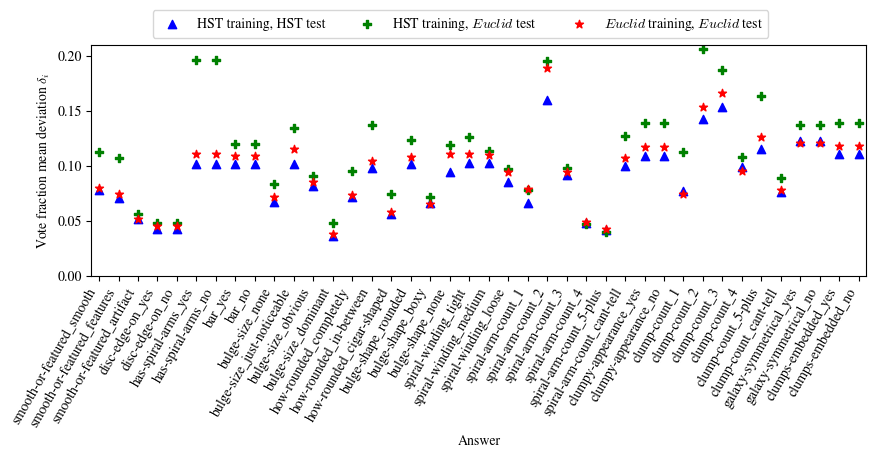

In [ ]:
#Scatter plot
#Predictions on bright and complete test set on one plot
questions_hubble = list(hubble_schema.question_answer_pairs.keys())
answers_hubble = hubble_schema.label_cols
answer_indices_hubble = hubble_schema.question_index_groups

answers_hubble = [answer.replace("-hubble","").replace("-larger-object","").replace("disk","disc") for answer in answers_hubble]

plt.figure(figsize=(10,3))
plt.scatter(answers_hubble,deviations_hubble_complete_B,label="HST training, HST test",marker="^",color="blue")
plt.scatter(answers_hubble,deviations_hubble_complete_B_euclid,label="HST training, $\it{Euclid}$ test",marker="P",color="green")
plt.scatter(answers_hubble,deviations_euclid_complete_B,label="$\it{Euclid}$ training, $\it{Euclid}$ test",marker="*",color="red")

#questions_sep = [2.5,4.5,6.5,8.5,12.5,15.5,18.5,21.5,27.5,29.5,35.5,37.5]
#for i in range(len(questions_sep)):
#    plt.vlines(questions_sep[i],0.0,0.4,linewidth=1,color="grey")

plt.margins(0.01)
#plt.axvline(0, ls='-', color='black')
plt.xlabel("Answer")
plt.ylabel("Vote fraction mean deviation $\delta_i$")
#plt.grid(axis="y")
plt.xticks(rotation=60, ha='right')
plt.ylim(0.0,0.21)
plt.legend(bbox_to_anchor=(0.07, 1), loc="lower left",ncol=3)
plt.savefig("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/plots/deviations_Hubble_Euclid_scatter.pdf",bbox_inches='tight')
plt.show()

#### Histogram of deviations

0.08082815422545818
-0.40837939256903466
-1.2849814850623604
-0.06923930121209568
0.06923930121209573
-1.262486013112574
1.262486013112574
-0.7472889765833567
0.7472889765833566
-0.43704167897957114
0.43704167897957136


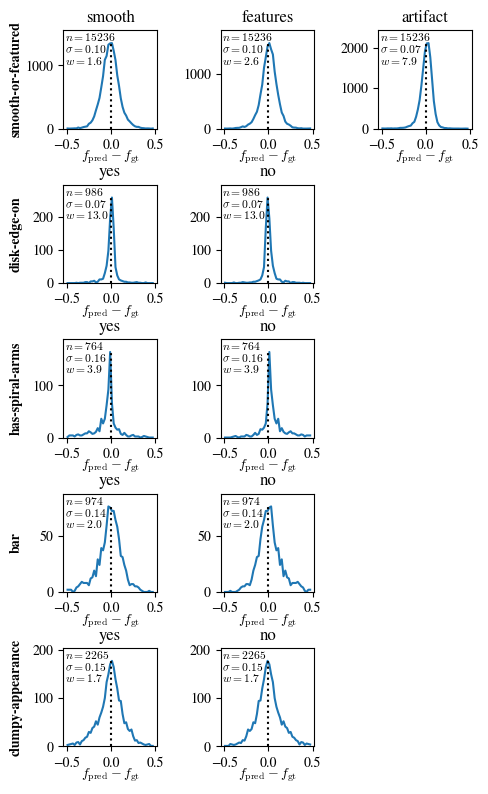

In [ ]:
#Histogram for vote fraction mean deviations
fig, ax = plt.subplots(nrows=5, ncols=3,figsize=(5,8))
fig.tight_layout(pad=2)
indices_answers = [[0,1,2],[3,4],[5,6],[7,8],[28,29]]
for i in range(len(indices_answers)):
    ax[i,0].text(-0.5,0.5, answers_hubble[indices_answers[i][0]].split("_")[0], rotation='vertical', horizontalalignment='center', verticalalignment='center',transform = ax[i,0].transAxes,weight='bold')
    for j in range(len(indices_answers[i])):
        bins = np.arange(-0.5,0.5,0.02)
        hist = np.histogram(deviations_hubble_complete_B_complete_all[indices_answers[i][j]],bins=bins)
        ax[i,j].plot(hist[1][:-1]+0.01,hist[0])
        ax[i,j].vlines(0,0,np.max(hist[0])*1.0,color="black",linestyle="dotted")
        ax[i,j].set_ylim(0,np.max(hist[0])*1.15)
        ax[i,j].set_title(answers_hubble[indices_answers[i][j]].split("_")[1])
        ax[i,j].text(-0.52,np.max(hist[0])*1.02,"$n={}$".format(len(deviations_hubble_complete_B_complete_all[indices_answers[i][j]])),fontsize="small")
        sigma = np.std(deviations_hubble_complete_B_complete_all[indices_answers[i][j]])
        kurtosis = stats.kurtosis(deviations_hubble_complete_B_complete_all[indices_answers[i][j]])
        skewness = stats.skew(deviations_hubble_complete_B_complete_all[indices_answers[i][j]])
        print(skewness)
        ax[i,j].text(-0.52,np.max(hist[0])*0.88,"$\sigma={:.2f}$".format(sigma),fontsize="small")
        ax[i,j].text(-0.52,np.max(hist[0])*0.75,"$w={:.1f}$".format(kurtosis),fontsize="small")
        ax[i,j].set_xlabel("$f_{\mathrm{pred}}-f_{\mathrm{gt}}$",labelpad=-2)
fig.delaxes(ax[1,2])
fig.delaxes(ax[2,2])
fig.delaxes(ax[3,2])
fig.delaxes(ax[4,2])
plt.savefig("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/plots/histograms_deviations_selected_hubble.pdf",bbox_inches='tight')
plt.show()

## Physical parameters (best model)

In [21]:
save_path_csv = "/content/drive/MyDrive/MPE/ZoobotEuclid/Results/euclid/complete/weights_B/num_galaxies_60940/test_predictions.csv"
data = pd.read_csv(save_path_csv)

In [22]:
data[["id_str","Z_BEST","MAG_BEST_HI","smooth-or-featured-hubble_smooth_pred_frac","smooth-or-featured-hubble_smooth_frac"]]

id_str   Z_BEST  MAG_BEST_HI  \
0       /content/jpgs_euclid_complete/20000347.jpg  999.000      21.5986   
1       /content/jpgs_euclid_complete/20000358.jpg  999.000      23.4567   
2       /content/jpgs_euclid_complete/20000380.jpg    1.316      22.5915   
3       /content/jpgs_euclid_complete/20000575.jpg  999.000      22.6611   
4       /content/jpgs_euclid_complete/20000609.jpg  999.000      22.6972   
...                                            ...      ...          ...   
15231  /content/jpgs_euclid_complete/201827042.jpg    0.306      20.1270   
15232  /content/jpgs_euclid_complete/201858002.jpg  999.000      23.2383   
15233  /content/jpgs_euclid_complete/201903062.jpg    2.018      23.1217   
15234  /content/jpgs_euclid_complete/201989002.jpg    0.232      22.1965   
15235  /content/jpgs_euclid_complete/202000022.jpg  999.000      23.1738   

       smooth-or-featured-hubble_smooth_pred_frac  \
0                                        0.728663   
1                                        0.570401   
2                                        0.276221   
3                                        0.762879   
4                                        0.682285   
...                                           ...   
15231                                    0.112016   
15232                                    0.333595   
15233                                    0.247694   
15234                                    0.624685   
15235                                    0.673004   

       smooth-or-featured-hubble_smooth_frac  
0                                   0.674419  
1                                   0.580000  
2                                   0.244444  
3                                   0.818182  
4                                   0.621622  
...                                      ...  
15231                               0.357143  
15232                               0.407407  
15233                               0.181818  
15234                               0.540541  
15235                               0.607143  

[15236 rows x 5 columns]

### Fraction depending on redshift and magnitude

In [ ]:
def binning_answers(bins,data,question,answers,column_name="Z_BEST",ending="_pred_frac"):
    #Get number of volunteers
    number_votes = data["smooth-or-featured-hubble_number"]
    half_num_votes = np.array(number_votes)/2

    data_half = data[data[question+"_number"]>=half_num_votes][(data[column_name]>bins[0]) & (data[column_name]<bins[-1])]

    fracs = []
    for i in range(len(answers)):
        frac, num_galaxies = [], []
        for j in range(len(bins)-1):
            data_bin = data_half[(data_half[column_name]>bins[j]) & (data_half[column_name]<bins[j+1])]
            num_galaxies.append(len(data_bin))
            frac.append(np.mean(data_bin[answers[i]+ending]))
        #print("Mean vote fraction of {}: {:.2%}".format(answers[i],np.mean(data_half[answers[i]+ending])))
        fracs.append(frac)
    print(num_galaxies)
    return fracs,len(data_half)

[698, 1233, 2251, 1660, 2447, 2054, 1804, 953, 568]
[698, 1233, 2251, 1660, 2447, 2054, 1804, 953, 568]
smooth-or-featured-hubble
[33, 144, 260, 146, 168, 94, 72, 21, 5]
[33, 144, 260, 146, 168, 94, 72, 21, 5]
disk-edge-on-hubble


<ipython-input-47-2b3cf6ebd35a>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_half = data[data[question+"_number"]>=half_num_votes][(data[column_name]>bins[0]) & (data[column_name]<bins[-1])]


[21, 102, 204, 109, 131, 80, 60, 19, 4]
[21, 102, 204, 109, 131, 80, 60, 19, 4]
has-spiral-arms-hubble
[30, 124, 232, 135, 167, 115, 88, 28, 13]
[30, 124, 232, 135, 167, 115, 88, 28, 13]
bar-hubble
[30, 124, 232, 135, 167, 116, 88, 28, 13]
[30, 124, 232, 135, 167, 116, 88, 28, 13]
bulge-size-hubble
[421, 833, 1607, 1177, 1734, 1446, 1220, 578, 283]
[421, 833, 1607, 1177, 1734, 1446, 1220, 578, 283]
how-rounded-hubble
[7, 17, 28, 15, 11, 2, 0, 1, 0]
[7, 17, 28, 15, 11, 2, 0, 1, 0]
bulge-shape-hubble
[20, 100, 197, 102, 134, 83, 57, 19, 7]
[20, 100, 197, 102, 134, 83, 57, 19, 7]
spiral-winding-hubble
[20, 100, 197, 102, 134, 83, 56, 19, 7]
[20, 100, 197, 102, 134, 83, 56, 19, 7]
spiral-arm-count-hubble
[71, 228, 395, 256, 341, 268, 242, 132, 90]
[71, 228, 395, 256, 341, 268, 242, 132, 90]
clumpy-appearance-hubble
[12, 26, 24, 25, 22, 30, 50, 31, 30]
[12, 26, 24, 25, 22, 30, 50, 31, 30]
clump-count-hubble
[6, 13, 17, 16, 13, 15, 34, 23, 23]
[6, 13, 17, 16, 13, 15, 34, 23, 23]
galaxy-symme

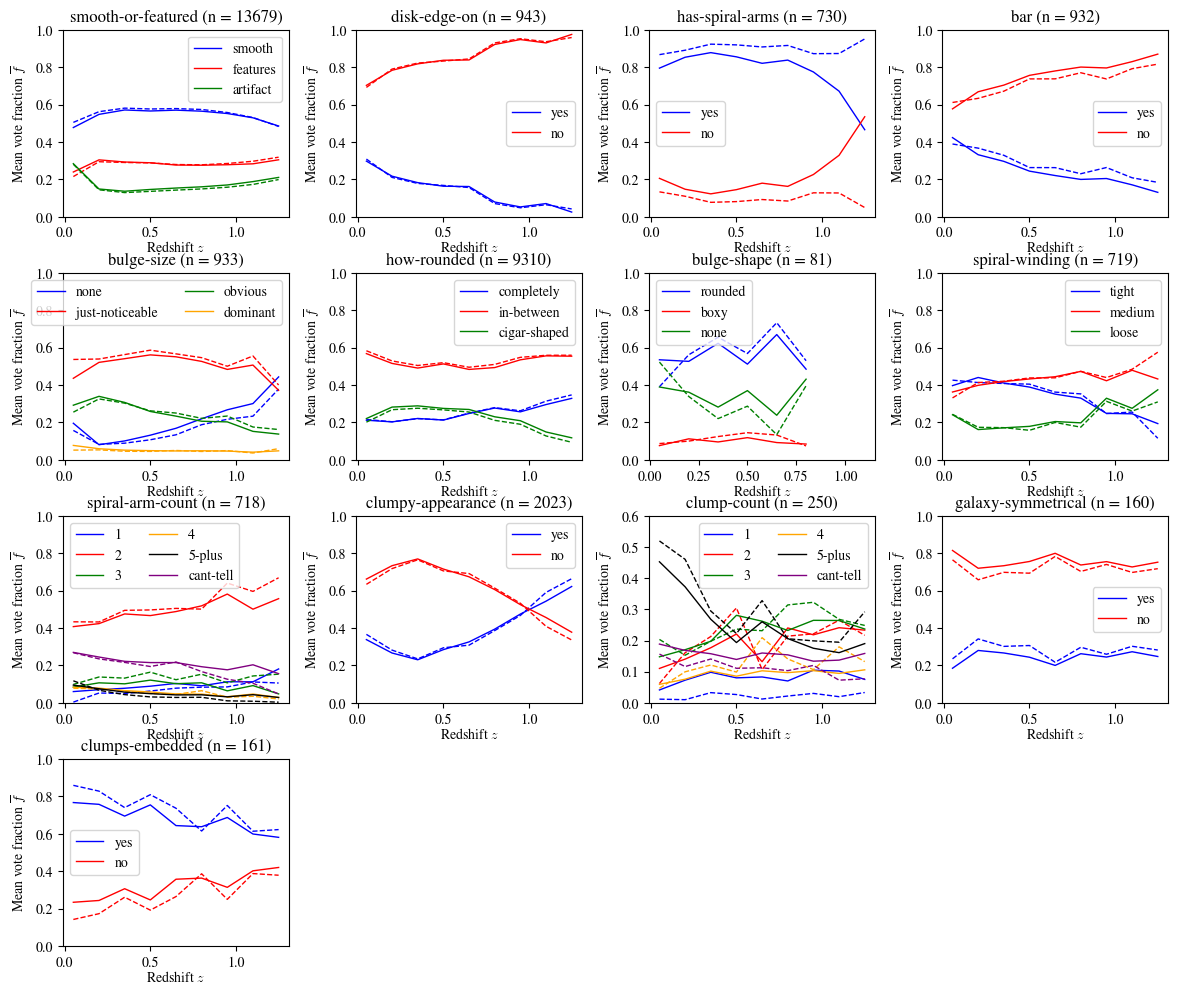

In [ ]:
#Plot for all questions
bins_z = np.arange(0,1.5,0.15)
questions = list(hubble_schema.question_answer_pairs.keys())
answers = hubble_schema.label_cols
answer_indices = hubble_schema.question_index_groups

fig, ax = plt.subplots(nrows=4, ncols=4,figsize=(12,10))
fig.tight_layout(pad=2)
ax = ax.flatten()
colors = ["blue","red","green","orange","black","purple","pink"]

for i in range(len(questions)):
    answers_q = answers[answer_indices[i][0]:answer_indices[i][1]+1]
    fracs_pred, num_answers = binning_answers(bins_z,data,questions[i],answers_q,column_name="Z_BEST",ending="_pred_frac")
    fracs_gt, num_answers = binning_answers(bins_z,data,questions[i],answers_q,column_name="Z_BEST",ending="_frac")
    for j in range(len(answers_q)):
        ax[i].errorbar(bins_z[:-1]+0.05,fracs_pred[j],linestyle="-",linewidth=1,markersize=10,color=colors[j],label=answers_q[j].split("_")[1])
        ax[i].errorbar(bins_z[:-1]+0.05,fracs_gt[j],linestyle="--",linewidth=1,markersize=10,color=colors[j])
    if len(answers_q) >= 4:
        ax[i].legend(ncol=2)
    else:
        ax[i].legend()
    if i == 10:
        ax[i].set_ylim(0,0.6)
    else:
        ax[i].set_ylim(0,1)
    ax[i].set_xlabel("Redshift $z$",labelpad=0)
    ax[i].set_ylabel("Mean vote fraction $\overline{f}$")

    ax[i].set_title(questions[i].replace("-hubble","").replace("-larger-object","").replace("disk","disc")+" (n = {})".format(num_answers))
    print(questions[i])
fig.delaxes(ax[13])
fig.delaxes(ax[14])
fig.delaxes(ax[15])
plt.savefig("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/plots/redshift_fraction_questions.pdf",bbox_inches='tight')

smooth-or-featured-hubble
[72, 153, 177, 281, 436, 737, 1067, 1584, 2285, 3388, 4893]
[72, 153, 177, 281, 436, 737, 1067, 1584, 2285, 3388, 4893]
disk-edge-on-hubble
[24, 52, 72, 119, 133, 177, 167, 114, 62, 33, 9]
[24, 52, 72, 119, 133, 177, 167, 114, 62, 33, 9]
has-spiral-arms-hubble
[19, 43, 52, 94, 108, 141, 126, 88, 40, 25, 7]
[19, 43, 52, 94, 108, 141, 126, 88, 40, 25, 7]
bar-hubble


<ipython-input-47-2b3cf6ebd35a>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_half = data[data[question+"_number"]>=half_num_votes][(data[column_name]>bins[0]) & (data[column_name]<bins[-1])]


[20, 45, 65, 106, 127, 170, 166, 135, 70, 36, 12]
[20, 45, 65, 106, 127, 170, 166, 135, 70, 36, 12]
bulge-size-hubble
[20, 45, 65, 106, 127, 170, 166, 136, 70, 36, 12]
[20, 45, 65, 106, 127, 170, 166, 136, 70, 36, 12]
how-rounded-hubble
[13, 28, 56, 98, 187, 377, 604, 1013, 1571, 2452, 3504]
[13, 28, 56, 98, 187, 377, 604, 1013, 1571, 2452, 3504]
bulge-shape-hubble
[1, 5, 7, 8, 13, 15, 15, 6, 11, 2, 0]
[1, 5, 7, 8, 13, 15, 15, 6, 11, 2, 0]
spiral-winding-hubble
[14, 42, 54, 91, 106, 135, 131, 88, 41, 21, 4]
[14, 42, 54, 91, 106, 135, 131, 88, 41, 21, 4]
spiral-arm-count-hubble
[14, 42, 54, 91, 106, 135, 131, 88, 40, 21, 4]
[14, 42, 54, 91, 106, 135, 131, 88, 40, 21, 4]
clumpy-appearance-hubble
[27, 64, 97, 150, 206, 280, 328, 357, 290, 250, 189]
[27, 64, 97, 150, 206, 280, 328, 357, 290, 250, 189]
clump-count-hubble
[1, 2, 9, 5, 14, 25, 34, 42, 61, 62, 73]
[1, 2, 9, 5, 14, 25, 34, 42, 61, 62, 73]
galaxy-symmetrical-hubble
[0, 0, 4, 1, 6, 14, 18, 21, 45, 48, 68]
[0, 0, 4, 1, 6, 14, 18, 

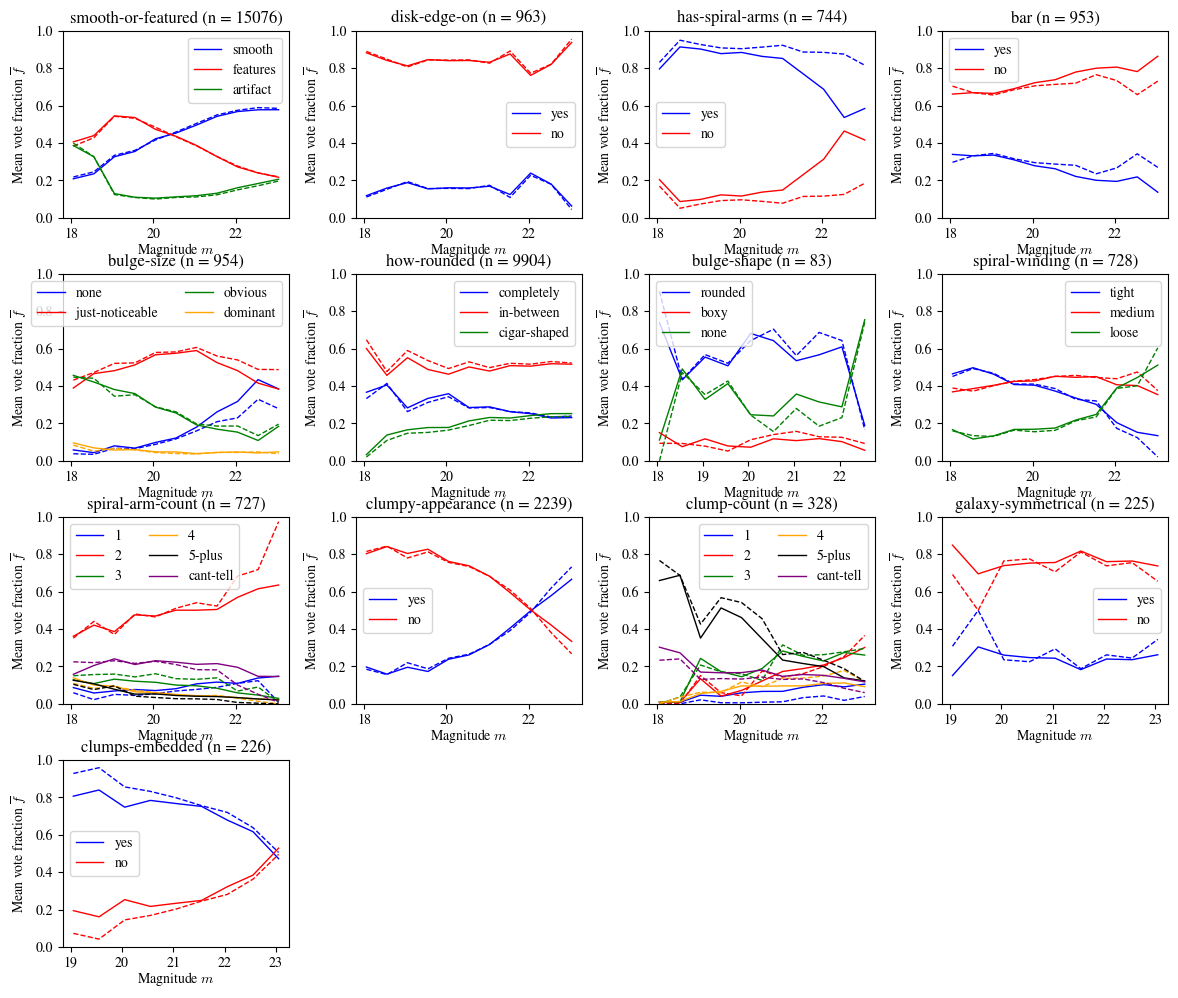

In [ ]:
bins_mag = np.arange(18,24,0.5)
questions = list(hubble_schema.question_answer_pairs.keys())
answers = hubble_schema.label_cols
answer_indices = hubble_schema.question_index_groups

fig, ax = plt.subplots(nrows=4, ncols=4,figsize=(12,10))
fig.tight_layout(pad=2)
ax = ax.flatten()
colors = ["blue","red","green","orange","black","purple","pink"]

for i in range(len(questions)):
    print(questions[i])
    answers_q = answers[answer_indices[i][0]:answer_indices[i][1]+1]
    fracs_pred, num_answers = binning_answers(bins_mag,data,questions[i],answers_q,column_name="MAG_BEST_HI",ending="_pred_frac")
    fracs_gt, num_answers = binning_answers(bins_mag,data,questions[i],answers_q,column_name="MAG_BEST_HI",ending="_frac")
    for j in range(len(answers_q)):
        ax[i].errorbar(bins_mag[:-1]+0.05,fracs_pred[j],linestyle="-",linewidth=1,markersize=10,color=colors[j],label=answers_q[j].split("_")[1])
        ax[i].errorbar(bins_mag[:-1]+0.05,fracs_gt[j],linestyle="--",linewidth=1,markersize=10,color=colors[j])
    if len(answers_q) >= 4:
        ax[i].legend(ncol=2)
    else:
        ax[i].legend()
    ax[i].set_xlabel("Magnitude $m$",labelpad=0)
    ax[i].set_ylabel("Mean vote fraction $\overline{f}$")
    ax[i].set_ylim(0,1)
    ax[i].set_title(questions[i].replace("-hubble","").replace("-larger-object","").replace("disk","disc")+" (n = {})".format(num_answers))
fig.delaxes(ax[13])
fig.delaxes(ax[14])
fig.delaxes(ax[15])
plt.savefig("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/plots/mag_fraction_questions.pdf",bbox_inches='tight')

160
66


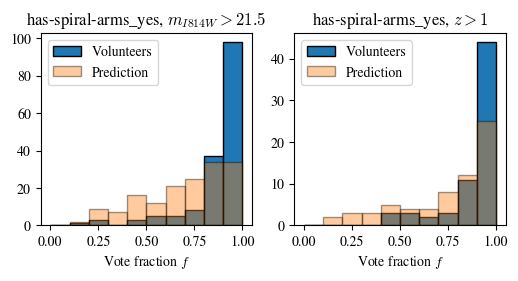

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(6,2.5))

data_high_mag = data[(data["MAG_BEST_HI"]>21.5) & (data["has-spiral-arms-hubble_number"]>=data["smooth-or-featured-hubble_number"]/2)]
print(len(data_high_mag))
bins = np.arange(0,1.05,0.1)
spiral_labels = np.histogram(data_high_mag["has-spiral-arms-hubble_yes_frac"],bins=bins)
spiral_pred = np.histogram(data_high_mag["has-spiral-arms-hubble_yes_pred_frac"],bins=bins)

ax[0].bar(bins[:-1]+0.05,spiral_labels[0],width=0.1,label="Volunteers",edgecolor="black")
ax[0].bar(bins[:-1]+0.05,spiral_pred[0],width=0.1,label="Prediction",alpha=0.4,edgecolor="black")
ax[0].set_xlabel("Vote fraction $f$")
ax[0].set_title("has-spiral-arms_yes, $m_{I814W}>21.5$")
ax[0].legend()

data_high_z = data[(data["Z_BEST"]>1) & (data["has-spiral-arms-hubble_number"]>=data["smooth-or-featured-hubble_number"]/2)]
print(len(data_high_z))
bins = np.arange(0,1.05,0.1)
spiral_labels = np.histogram(data_high_z["has-spiral-arms-hubble_yes_frac"],bins=bins)
spiral_pred = np.histogram(data_high_z["has-spiral-arms-hubble_yes_pred_frac"],bins=bins)

ax[1].bar(bins[:-1]+0.05,spiral_labels[0],width=0.1,label="Volunteers",edgecolor="black")
ax[1].bar(bins[:-1]+0.05,spiral_pred[0],width=0.1,label="Prediction",alpha=0.4,edgecolor="black")
ax[1].set_xlabel("Vote fraction $f$")
ax[1].set_title("has-spiral-arms_yes, $z>1$")
ax[1].legend()
plt.savefig("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/plots/histograms_spiral.pdf",bbox_inches='tight')

In [ ]:
save_path_csv = "/content/drive/MyDrive/MPE/ZoobotEuclid/Results/hubble/complete/weights_B/num_galaxies_60940/test_predictions.csv"
data_hubble = pd.read_csv(save_path_csv)

<ipython-input-42-2b3cf6ebd35a>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_half = data[data[question+"_number"]>=half_num_votes][(data[column_name]>bins[0]) & (data[column_name]<bins[-1])]


[19, 43, 52, 94, 108, 141, 126, 88, 40, 25, 7]
[19, 43, 52, 94, 108, 141, 126, 88, 40, 25, 7]
[21, 102, 204, 109, 131, 80, 60, 19, 4]
[21, 102, 204, 109, 131, 80, 60, 19, 4]


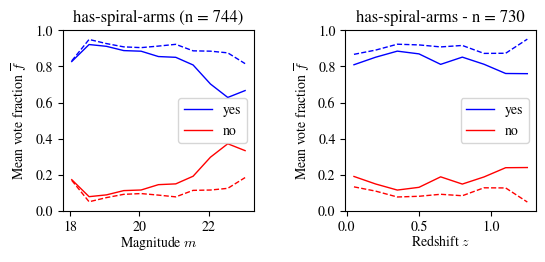

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(6.2,3.2))
fig.tight_layout(pad=4)
bins_mag = np.arange(18,24,0.5)
answers = ["has-spiral-arms-hubble_yes","has-spiral-arms-hubble_no"]
colors = ["blue","red","green","orange","black","purple","pink"]

fracs_pred, num_answers = binning_answers(bins_mag,data_hubble,"has-spiral-arms-hubble",answers,column_name="MAG_BEST_HI",ending="_pred_frac")
fracs_gt, num_answers = binning_answers(bins_mag,data_hubble,"has-spiral-arms-hubble",answers,column_name="MAG_BEST_HI",ending="_frac")
for j in range(len(answers)):
    ax[0].errorbar(bins_mag[:-1]+0.05,fracs_pred[j],linestyle="-",linewidth=1,markersize=10,color=colors[j],label=answers[j].split("_")[1])
    ax[0].errorbar(bins_mag[:-1]+0.05,fracs_gt[j],linestyle="--",linewidth=1,markersize=10,color=colors[j])
ax[0].legend()
ax[0].set_ylim(0,1)
ax[0].set_xlabel("Magnitude $m$",labelpad=0)
ax[0].set_ylabel("Mean vote fraction $\overline{f}$")
ax[0].set_title("has-spiral-arms (n = {})".format(num_answers))

#Plot for all questions
bins_z = np.arange(0,1.5,0.15)
answers = ["has-spiral-arms-hubble_yes","has-spiral-arms-hubble_no"]

fracs_pred, num_answers = binning_answers(bins_z,data_hubble,"has-spiral-arms-hubble",answers,column_name="Z_BEST",ending="_pred_frac")
fracs_gt, num_answers = binning_answers(bins_z,data_hubble,"has-spiral-arms-hubble",answers,column_name="Z_BEST",ending="_frac")
for j in range(len(answers)):
    ax[1].errorbar(bins_z[:-1]+0.05,fracs_pred[j],linestyle="-",linewidth=1,markersize=10,color=colors[j],label=answers[j].split("_")[1])
    ax[1].errorbar(bins_z[:-1]+0.05,fracs_gt[j],linestyle="--",linewidth=1,markersize=10,color=colors[j])
ax[1].legend()
ax[1].set_ylim(0,1)
ax[1].set_xlabel("Redshift $z$",labelpad=0)
ax[1].set_ylabel("Mean vote fraction $\overline{f}$")
ax[1].set_title("has-spiral-arms - n = {}".format(num_answers))
plt.savefig("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/plots/redshift_mag_hubble.pdf",bbox_inches='tight')

### Mean deviation depending on redshift and magnitude

In [23]:
def binning_answers_diffs(bins,data,question,answers,column_name="Z_BEST"):
    #Get number of volunteers
    number_votes = data["smooth-or-featured-hubble_number"]
    half_num_votes = np.array(number_votes)/2

    data_half = data[data[question+"_number"]>=half_num_votes][(data[column_name]>bins[0]) & (data[column_name]<bins[-1])]

    diffs, diffs_err = [], []
    for i in range(len(answers)):
        deviations, num_galaxies, deviations_err = [], [], []
        for j in range(len(bins)-1):
            data_bin = data_half[(data_half[column_name]>bins[j]) & (data_half[column_name]<bins[j+1])]
            num_galaxies.append(len(data_bin))
            predictions, labels = [], []
            for k in range(len(data_bin)):
                predictions.append(data_bin[answers[i]+"_pred_frac"].iloc[k])
                labels.append(data_bin[answers[i]+"_frac"].iloc[k])
            deviations_abs = np.abs(np.array(predictions)-np.array(labels))
            deviations.append(np.mean(deviations_abs))
            deviations_err.append(np.std(deviations_abs)/np.sqrt(len(data_bin)))
        diffs.append(deviations)
        diffs_err.append(deviations_err)
    return diffs,diffs_err,len(data_half)

<ipython-input-23-063ebdfc1771>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_half = data[data[question+"_number"]>=half_num_votes][(data[column_name]>bins[0]) & (data[column_name]<bins[-1])]
<ipython-input-23-063ebdfc1771>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_half = data[data[question+"_number"]>=half_num_votes][(data[column_name]>bins[0]) & (data[column_name]<bins[-1])]
<ipython-input-23-063ebdfc1771>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_half = data[data[question+"_number"]>=half_num_votes][(data[column_name]>bins[0]) & (data[column_name]<bins[-1])]
<ipython-input-23-063ebdfc1771>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_half = data[data[question+"_number"]>=half_num_votes][(data[column_name]>bins[0]) & (data[column_name]<bins[-1])]
<ipython-input-23-063ebdfc1771>:6: UserWarning: Boolean Series key will 

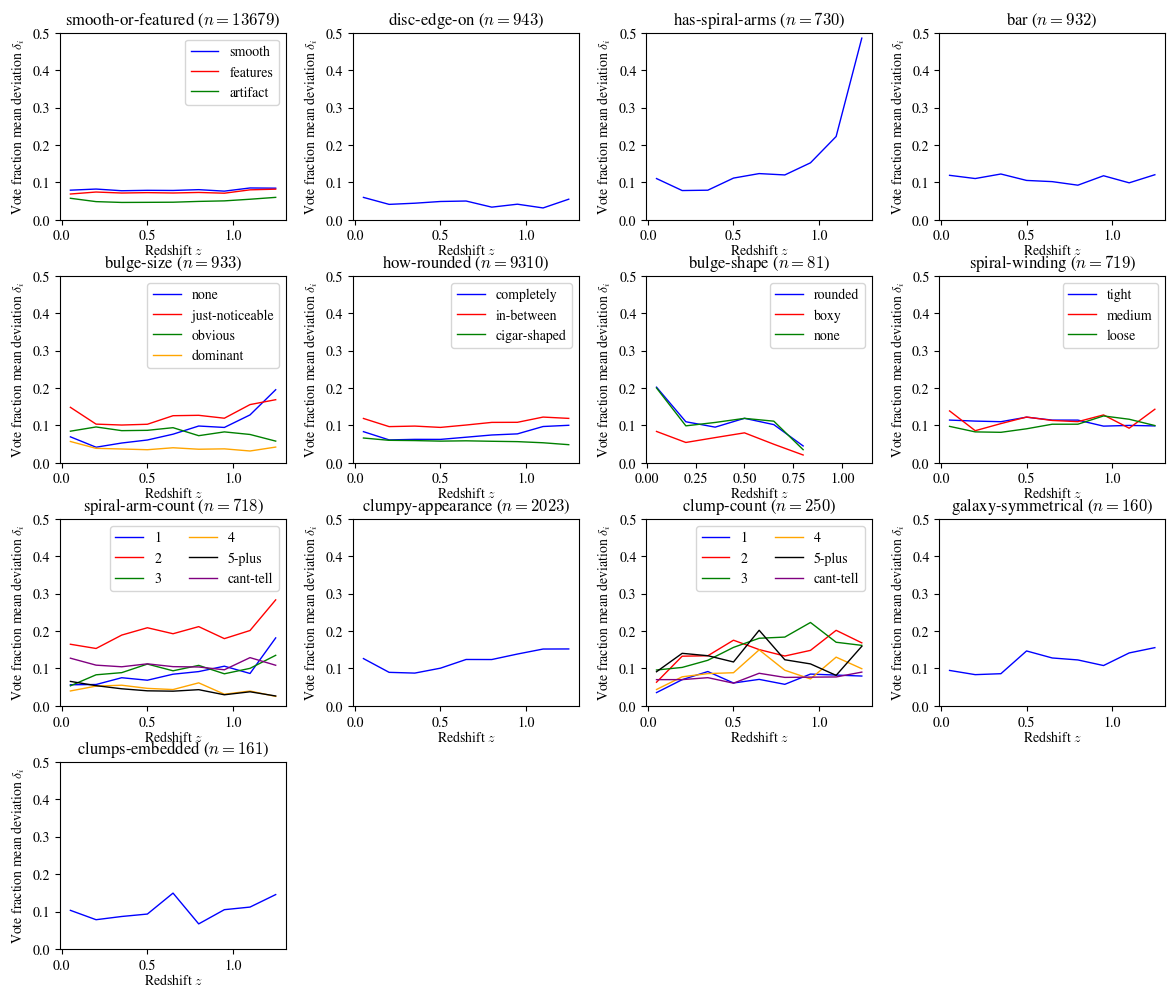

In [26]:
#Plot for all questions
bins_z = np.arange(0,1.5,0.15)
questions = list(hubble_schema.question_answer_pairs.keys())
answers = hubble_schema.label_cols
answer_indices = hubble_schema.question_index_groups

fig, ax = plt.subplots(nrows=4, ncols=4,figsize=(12,10))
fig.tight_layout(pad=2)
ax = ax.flatten()
colors = ["blue","red","green","orange","black","purple","pink"]

for i in range(len(questions)):
    answers_q = answers[answer_indices[i][0]:answer_indices[i][1]+1]
    diffs, diffs_err, num_answers = binning_answers_diffs(bins_z,data,questions[i],answers_q,column_name="Z_BEST")
    if len(answers_q) > 2:
        for j in range(len(answers_q)):
            ax[i].plot(bins_z[:-1]+0.05,diffs[j],linestyle="-",linewidth=1,markersize=10,color=colors[j],label=answers_q[j].split("_")[1])
            #tops = np.array(diffs[j]) + np.array(diffs_err[j])
            #bottoms = np.array(diffs[j]) - np.array(diffs_err[j])
            #ax[i].fill_between(bins_z[:-1]+0.05, bottoms, tops, color=colors[j], alpha=0.2)
        if len(answers_q) >= 5:
            ax[i].legend(ncol=2)
        else:
            ax[i].legend()
    else:
        ax[i].plot(bins_z[:-1]+0.05,diffs[0],linestyle="-",linewidth=1,markersize=10,color=colors[0])
        #tops = np.array(diffs[0]) + np.array(diffs_err[0])
        #bottoms = np.array(diffs[0]) - np.array(diffs_err[0])
        #ax[i].fill_between(bins_z[:-1]+0.05, bottoms, tops, color=colors[0], alpha=0.2)
    ax[i].set_ylim(0,0.5)
    ax[i].set_xlabel("Redshift $z$",labelpad=0)
    ax[i].set_ylabel("Vote fraction mean deviation $\delta_i$")

    ax[i].set_title(questions[i].replace("-hubble","").replace("disk","disc").replace("-larger-object","")+" ($n = {}$)".format(num_answers))
fig.delaxes(ax[13])
fig.delaxes(ax[14])
fig.delaxes(ax[15])
plt.savefig("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/plots/redshift_diffs.pdf",bbox_inches='tight')

<ipython-input-23-063ebdfc1771>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_half = data[data[question+"_number"]>=half_num_votes][(data[column_name]>bins[0]) & (data[column_name]<bins[-1])]
<ipython-input-23-063ebdfc1771>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_half = data[data[question+"_number"]>=half_num_votes][(data[column_name]>bins[0]) & (data[column_name]<bins[-1])]
<ipython-input-23-063ebdfc1771>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_half = data[data[question+"_number"]>=half_num_votes][(data[column_name]>bins[0]) & (data[column_name]<bins[-1])]
<ipython-input-23-063ebdfc1771>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_half = data[data[question+"_number"]>=half_num_votes][(data[column_name]>bins[0]) & (data[column_name]<bins[-1])]
<ipython-input-23-063ebdfc1771>:6: UserWarning: Boolean Series key will 

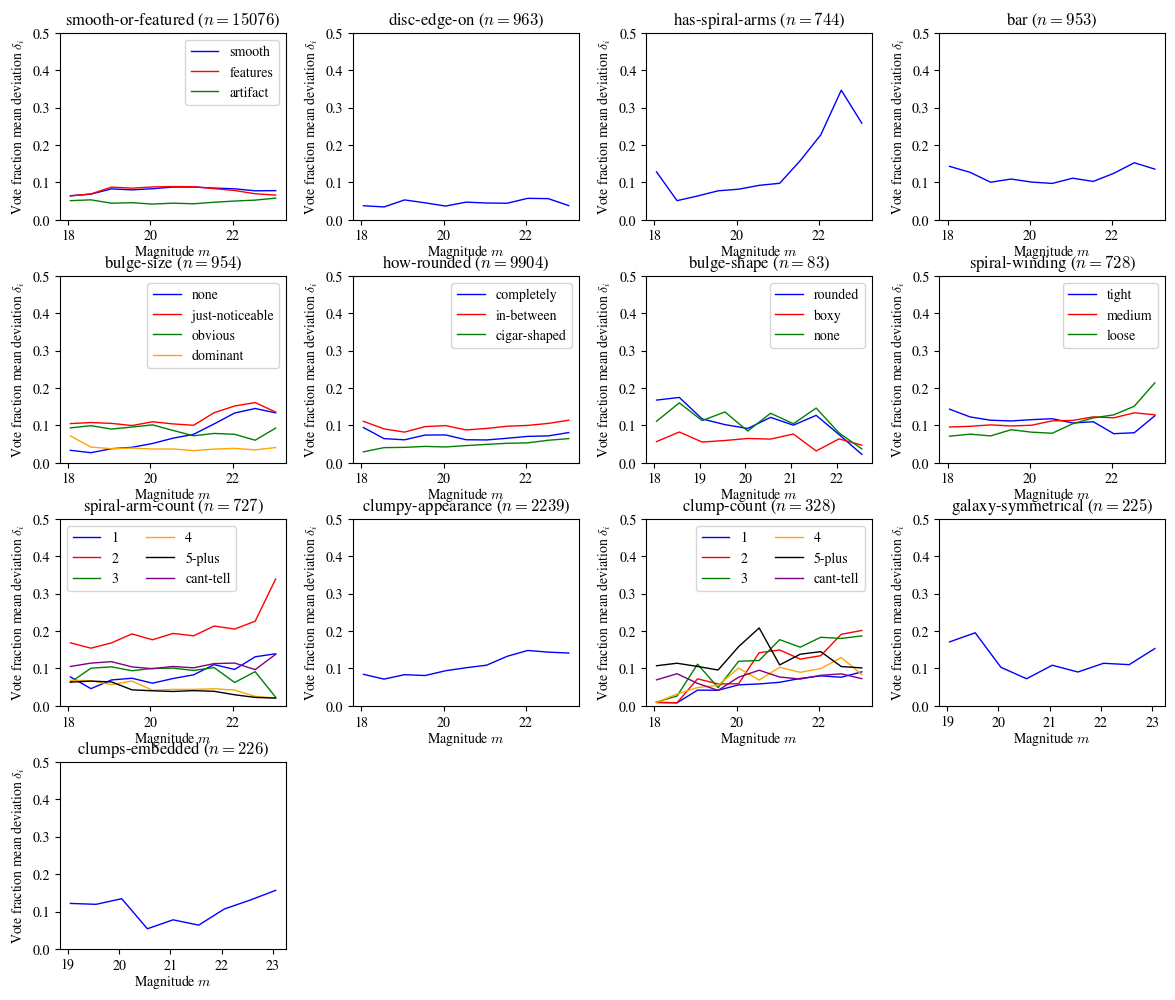

In [27]:
bins_mag = np.arange(18,24,0.5)
questions = list(hubble_schema.question_answer_pairs.keys())
answers = hubble_schema.label_cols
answer_indices = hubble_schema.question_index_groups

fig, ax = plt.subplots(nrows=4, ncols=4,figsize=(12,10))
fig.tight_layout(pad=2)
ax = ax.flatten()
colors = ["blue","red","green","orange","black","purple","pink"]

for i in range(len(questions)):
    answers_q = answers[answer_indices[i][0]:answer_indices[i][1]+1]
    diffs, diffs_err, num_answers = binning_answers_diffs(bins_mag,data,questions[i],answers_q,column_name="MAG_BEST_HI")
    if len(answers_q) > 2:
        for j in range(len(answers_q)):
            ax[i].plot(bins_mag[:-1]+0.05,diffs[j],linestyle="-",linewidth=1,markersize=10,color=colors[j],label=answers_q[j].split("_")[1])
            #tops = np.array(diffs[j]) + np.array(diffs_err[j])
            #bottoms = np.array(diffs[j]) - np.array(diffs_err[j])
            #ax[i].fill_between(bins_mag[:-1]+0.05, bottoms, tops, color=colors[j], alpha=0.2)
        if len(answers_q) >= 5:
            ax[i].legend(ncol=2)
        else:
            ax[i].legend()
    else:
        ax[i].plot(bins_mag[:-1]+0.05,diffs[0],linestyle="-",linewidth=1,markersize=10,color=colors[0])
        #tops = np.array(diffs[0]) + np.array(diffs_err[0])
        #bottoms = np.array(diffs[0]) - np.array(diffs_err[0])
        #ax[i].fill_between(bins_mag[:-1]+0.05, bottoms, tops, color=colors[0], alpha=0.2)
    ax[i].set_ylim(0,0.5)
    ax[i].set_xlabel("Magnitude $m$",labelpad=0)
    ax[i].set_ylabel("Vote fraction mean deviation $\delta_i$")

    ax[i].set_title(questions[i].replace("-hubble","").replace("-larger-object","").replace("disk","disc")+" ($n = {}$)".format(num_answers))
fig.delaxes(ax[13])
fig.delaxes(ax[14])
fig.delaxes(ax[15])
plt.savefig("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/plots/mag_diffs.pdf",bbox_inches='tight')

In [ ]:
save_path_csv = "/content/drive/MyDrive/MPE/ZoobotEuclid/Results/hubble/complete/weights_B/num_galaxies_60940/test_predictions.csv"
data_hubble = pd.read_csv(save_path_csv)

<ipython-input-69-063ebdfc1771>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_half = data[data[question+"_number"]>=half_num_votes][(data[column_name]>bins[0]) & (data[column_name]<bins[-1])]
<ipython-input-69-063ebdfc1771>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_half = data[data[question+"_number"]>=half_num_votes][(data[column_name]>bins[0]) & (data[column_name]<bins[-1])]


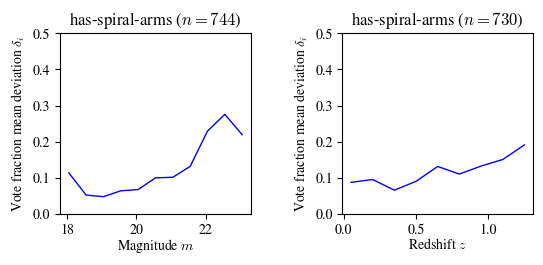

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(6.2,3.2))
fig.tight_layout(pad=4)
bins_mag = np.arange(18,24,0.5)
answers = ["has-spiral-arms-hubble_yes","has-spiral-arms-hubble_no"]
colors = ["blue","red","green","orange","black","purple","pink"]

diffs, diffs_err, num_answers = binning_answers_diffs(bins_mag,data_hubble,"has-spiral-arms-hubble",answers,column_name="MAG_BEST_HI")
ax[0].plot(bins_mag[:-1]+0.05,diffs[0],linestyle="-",linewidth=1,markersize=10,color=colors[0])
#tops = np.array(diffs[0]) + np.array(diffs_err[0])
#bottoms = np.array(diffs[0]) - np.array(diffs_err[0])
#ax[0].fill_between(bins_mag[:-1]+0.05, bottoms, tops, color=colors[0], alpha=0.2)
#ax[0].legend()
ax[0].set_ylim(0,0.5)
ax[0].set_xlabel("Magnitude $m$",labelpad=0)
ax[0].set_ylabel("Vote fraction mean deviation $\delta_i$")
ax[0].set_title("has-spiral-arms ($n = {}$)".format(num_answers))

#Plot for all questions
bins_z = np.arange(0,1.5,0.15)
answers = ["has-spiral-arms-hubble_yes","has-spiral-arms-hubble_no"]

diffs, diffs_err, num_answers = binning_answers_diffs(bins_z,data_hubble,"has-spiral-arms-hubble",answers,column_name="Z_BEST")
ax[1].plot(bins_z[:-1]+0.05,diffs[0],linestyle="-",linewidth=1,markersize=10,color=colors[0])
#tops = np.array(diffs[0]) + np.array(diffs_err[0])
#bottoms = np.array(diffs[0]) - np.array(diffs_err[0])
#ax[1].fill_between(bins_z[:-1]+0.05, bottoms, tops, color=colors[0], alpha=0.2)
#ax[1].legend()
ax[1].set_ylim(0,0.5)
ax[1].set_xlabel("Redshift $z$",labelpad=0)
ax[1].set_ylabel("Vote fraction mean deviation $\delta_i$")
ax[1].set_title("has-spiral-arms ($n = {}$)".format(num_answers))
plt.savefig("/content/drive/MyDrive/MPE/ZoobotEuclid/Results/plots/redshift_mag_hubble.pdf",bbox_inches='tight')